<hr style="border: solid 3px Indigo;">

# <center><span style="font-family:Arial; font-style: italic;">Text Classification.</span></center>

## Contents
* [problem defination](#1)
* [Import Libraries](#2)
* [Prepare the data](#3)
* [Preprocessing and Data Cleaning](#4)
* [Feature Engineering](#5)
  - [bag of words](#6)
  - [Bag of N-Grams Model](#7)
  - [TF-IDF Model](#8)
* [Models Training and Evaluation ](#9)
  - [train without cross validation](#10)
  - [Perform Evaluation on models that train without cross validation](#11)
  - [train with cross validation](#12)
  - [Perform Evaluation on models that train with cross validation](#13)
* [Perform Evaluation](#14)
* [Compare and decide which algorithm is performing as the champion model](#15)
* [Perform Error Analysis](#16)
* [Track varying of champion model](#17)
  - [Track lack of features ](#18)
  - [Track lack of data ](#19)
  - [Track stemmer and remove stop word effect on model  ](#20)
* [Retrain of champion model with data augmentation techniques](#21)





<hr style="border: solid 3px Brown;">
<a id="1"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Problem Defination</span></center>
the goal of this notebook is building text classification and apply multi features engineering techniques and multi model to get best models suitable to this case  

<hr style="border: solid 3px Brown;">
<a id="2"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Import Libraries</span></center>

In [ ]:
!pip install transformers
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from random import sample
import time
import nltk
from nltk.corpus import gutenberg 
from collections import Counter  # to get the most common words in a string 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import validation_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from wordcloud import WordCloud
from collections import Counter


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<hr style="border: solid 3px Brown;">
<a id="3"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">load the data</span></center>

### Getting Book names.

In [ ]:
books = gutenberg.fileids()
print(books)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [ ]:
chosen_books = ['austen-emma.txt', 'melville-moby_dick.txt', 'bryant-stories.txt', 'edgeworth-parents.txt', 'chesterton-ball.txt']

<hr style="border: solid 3px Brown;">
<a id="4"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Preprocessing and Data Cleaning</span></center>

### Function to remove headlines and titles

In [ ]:
def remove_head(paras):
    """
    INPUT:
    paras: list of paragraphs, each paragraph is a list of sentences,
     and each sentence is a list of words.

    OUTPUT:
    new_paras: the same as paras but after removing headlines and titles
      
    """
    new_paras = []
    for para in paras:
        para_len = 0
        for sent in para:
            para_len += len(sent)
        if para_len > 15:
            new_paras.append(para)    
    return new_paras

### Function to convert paragraphs to a list of words

In [ ]:
def para_to_list(paras):
    list1 = []
    for para in paras:
      for sent in para:
        for word in sent:
            list1.append(word)
    return list1

### Function to convert string to a list of words

In [ ]:
def str_to_list(text):
    list1 = re.split(r"\s+", text)
    return list1

### Function to clean the text

In [ ]:
def clean(text, flg_stemm, flg_stop):
    """
    INPUT:
    text: string of a text to be cleaned
    flg_stemm: bool to indicate whether stemming is to be applied
    flg_stop: bool to indicate whether to remoe stop words or not

    OUTPUT:
    new_text: list of words after cleaning, removing stop words, stemming

    """

    # Removing special characters, digits, and extra spaces
    new_text = re.sub(r"[^a-zA-Z']", ' ', text)
    print(f"The total number of words after removing special characters and digits is: {len(str_to_list(new_text))}")

    # Converting to lower case
    new_text = new_text.lower()

    # Tokenize the string
    new_text = str_to_list(new_text)

    # Removing stop words
    if flg_stop == True:
        lst_stopwords = nltk.corpus.stopwords.words("english")
        new_text = [word for word in new_text if word not in lst_stopwords]
        print(f"The total number of words after removing stop words is: {len(new_text)}")

    # Stemming
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        new_text = [ps.stem(word) for word in new_text]

    return new_text

### Function to divide the book into n words partitions base on words_num is given to function 

In [ ]:
def divide(list1, words_num):
    """
    INPUT: 
    list1: list of words
    words_num: number of words in each partition

    OUTPUT:
    partitions: list of partitions, each partition is a list of specific number of words.
    """
    partitions = []
    for i in range(0,len(list1)//words_num):
        partitions.append(list1[i*words_num:(i+1)*words_num])
    return partitions

### Function to put the partitions into dataframe

In [ ]:
def put_df(partitions, book, part_num):
    """
    INPUT:
    partitions: list of specific number of partitions, each partition is a list of specific number of words.
    book: the name of the book
    part_num: the number of partitions
    
    OUTPUT:
    df: The dataframe containing the text, list of words in the text, and book name.
    """
    list_partitions = []
    for part in partitions:
        list_partitions.append(' '.join(part))
    df = pd.DataFrame(list_partitions,columns=['text'])
    df['list_of_words'] = df['text'].apply(lambda x:x.split(' '))
    df['book_name'] = [re.split('[.]',book)[0]]*part_num
    return df

### Functions to make dataframe containing n random partitions by default 200 partations from each book in a list of books

In [ ]:
def make_df(list_books, words_num=100, part_num=200, flg_stemm=True, flg_stop=True ):
    """
    INPUT:
    list_books: list of books to get the text from
    words_num: the number of words per partition
    part_num: the number of partitions per book
    flg_stemm: bool to indicate whether stemming is to be applied
    flg_stop: bool to indicate whether to remoe stop words or not

    OUTPUT:
    df: The data frame contains n partitions from each book in the list of books

    """

    books_in_df = 0
    df = pd.DataFrame(columns=['text', 'list_of_words', 'book_name'])
    for book in list_books:

        print(f"Working with {re.split(r'[.]',book)[0]} book")

        #Removing headlines and titles
        paras = gutenberg.paras(book)
        print("The total number of paragraphs before removing headlines: {}".format(len(paras)))
        new_paras = remove_head(paras)
        print("The total number of paragraphs after removing headlines: {}".format(len(new_paras)))
    
        # Converting paragraphs to list of words
        list_words = para_to_list(new_paras)
        print("The total number of words is: {} ".format(len(list_words)))

        # Cleaning the text
        text = ' '.join(list_words)
        new_text = clean(text, flg_stemm, flg_stop)

        # Dividing the text into n words partitions
        partitions = divide(new_text, words_num)
        print(f"The total number of partitions is {len(partitions)}")

        # Choosing n random partitions and put them into the dataframe
        if len(partitions) < part_num:
            print("The total number of partitions in the book is less than {} partitions".format(part_num))
        else:
            chosen = sample(partitions, part_num)
            book_df = put_df(chosen, book, part_num)
            df = pd.concat([df, book_df])
        print()
    df =df.reset_index(drop=True)
    return df

### Putting books into the dataframe

In [ ]:
df = make_df(chosen_books)

Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines: 925
The total number of words is: 53068 
The total number of words after removing spec

### Printing sample from the dataframe

In [ ]:
df.sample(10)

text  \
547  old mother stood close boil kettl readi put co...   
101  ' side talk weather made answer think result t...   
991  present understand ' seem mean thing word minu...   
921  die univers uproar fieri vault head open middl...   
879  edit atheist fieri littl scotchman fieri red h...   
916  small sturdi fellow fine grey eye squar red ti...   
865  half present open door larg straw hat fallen b...   
809  past scilli isl much farther stood western sea...   
438  ' crafti shli ould fox ' fox tug away wid grea...   
118  circl emma began doubt whether wish indulg lon...   

                                         list_of_words        book_name  
547  [old, mother, stood, close, boil, kettl, readi...   bryant-stories  
101  [', side, talk, weather, made, answer, think, ...      austen-emma  
991  [present, understand, ', seem, mean, thing, wo...  chesterton-ball  
921  [die, univers, uproar, fieri, vault, head, ope...  chesterton-ball  
879  [edit, atheist, fieri, littl, scotchman, fieri...  chesterton-ball  
916  [small, sturdi, fellow, fine, grey, eye, squar...  chesterton-ball  
865  [half, present, open, door, larg, straw, hat, ...  chesterton-ball  
809  [past, scilli, isl, much, farther, stood, west...  chesterton-ball  
438  [', crafti, shli, ould, fox, ', fox, tug, away...   bryant-stories  
118  [circl, emma, began, doubt, whether, wish, ind...      austen-emma

<hr style="border: solid 3px Brown;">
<a id="5"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Feature Engineering</span></center>

<a id="6"></a> <br>
### bag of words

In [ ]:
def getBOW(train_corpus,test_corpus):
    """
    Function : Test_Model
    Used to test the model by label test set
    ---------------------------------
    Input : model, X_test set ,y_test set
    ---------------------------------
    Output : print the model accuracy and the visualization of wrong and correct point and the most partition that has 
    wrong class prediction
    """
    "it take train and test corpus and return train and test features"
    # build BOW features on train articles
    cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
    cv_train_features = cv.fit_transform(train_corpus)
    # transform test articles into features
    cv_test_features = cv.transform(test_corpus)
    return cv_train_features ,cv_test_features,cv


<a id="7"></a> <br>
### Bag of N-Grams Model

In [ ]:
def getNGram(n,train_corpus,test_corpus):
    "it take train and test corpus and return train and test features"
    # build BOW features on train articles
    bv = CountVectorizer(ngram_range=(n,n))
    bv_train_features = bv.fit_transform(train_corpus)
    # transform test articles into features
    bv_test_features = bv.transform(test_corpus)   
    return bv_train_features , bv_test_features,bv


<a id="8"></a> <br>
#### TF-IDF Model

In [ ]:
def getTF_IDF(train_corpus,test_corpus):
    "it take train and test corpus and return train and test features"
    # build BOW features on train articles
    tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
    tv_train_features = tv.fit_transform(train_corpus)
    # transform test articles into features
    tv_test_features = tv.transform(test_corpus)
    return tv_train_features , tv_test_features,tv

### Split the data to train and test

In [ ]:
def split_by(x,y,size):
    """
    Function : split_by
    Used to split data be persentage is given 
    ---------------------------------
    Input : x is train features data ,y label data,size split size
    ---------------------------------
    Output : X_train,X_test,y_train,y_test after split 
    """
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=size,random_state=42,stratify=y)
    return X_train,X_test,y_train,y_test

### get data base on features engnieering techniques

In [ ]:
def get_data(x,y,feature,cross_valid=False):
    """
    Function : get_data
    Used to split data and transform it be features engineering methods
    ---------------------------------
    Input : x is train features data ,y label data,feature the mothed it used to make transform to data ,cross_valid boolean value to split data on test ,train and validation or only to train and test default False
    ---------------------------------
    Output : X_train,X_test,X_valid,y_train,y_test,y_valid,courpus  X_valid and y_valid are none if cross validation unused and courpus the dictionary of words 
    """
    
    if cross_valid==True:
        X_tr,X_te,y_train,y_test=split_by(x,y,0.1)
        if feature=='BOW':
            X_train,X_test,courpus = getBOW(X_tr,X_te)
        elif feature=='n-gram':
            X_train,X_test,courpus = getNGram(2,X_tr,X_te)
        elif feature=='TF-IDF':
            X_train,X_test,courpus = getTF_IDF(X_tr,X_te)
        X_valid=y_valid=None
    else:
        X_tr,X_te,y_train,y_test_valid=split_by(x,y,0.2)
        if feature=='BOW':
            X_train,X_test_valid,courpus = getBOW(X_tr,X_te)
        elif feature=='n-gram':
            X_train,X_test_valid,courpus = getNGram(2,X_tr,X_te)
        elif feature=='TF-IDF':
            X_train,X_test_valid,courpus = getTF_IDF(X_tr,X_te)
        X_test,X_valid,y_test,y_valid=split_by(X_test_valid,y_test_valid,0.5)
    return X_train,X_test,X_valid,y_train,y_test,y_valid,courpus
    


### declare features engineering techniques and models they are used 

In [ ]:
Features_Engneering_names=['BOW','TF-IDF', 'n-gram']
models_names=['logistic regression','SVM', 'Decision Tree','RandomForest Classifier','GradientBoosting', 'k-Nearest Neighbor','naive base']

### get data after clean and features engineering 

In [ ]:
for feature in Features_Engneering_names:
  print('using {} in feature engineering'.format(feature))
  X_train,X_test,X_valid,y_train,y_test,y_valid,courpus=get_data(df.iloc[:,0],df.iloc[:,-1],feature,cross_valid=True)
  print(courpus.get_feature_names())
  print(X_train.toarray().shape)
  df_features=pd.DataFrame(X_train.toarray(),columns=courpus.get_feature_names())
  display(df_features.head())





using BOW in feature engineering
['abaft', 'abandon', 'abat', 'abbey', 'abbrevi', 'abhor', 'abhorr', 'abid', 'abil', 'abjectu', 'abl', 'aboard', 'abod', 'abomin', 'aborigin', 'abort', 'abound', 'abraham', 'abroad', 'abrupt', 'abruptli', 'absenc', 'absent', 'absolut', 'absorb', 'abstract', 'abstractedli', 'absurd', 'absurdli', 'abund', 'abundantli', 'abus', 'abyss', 'academi', 'acced', 'accent', 'accept', 'accid', 'accident', 'accommod', 'accompani', 'accomplic', 'accomplish', 'accord', 'accordingli', 'accost', 'account', 'accoutr', 'accru', 'accumul', 'accus', 'accustom', 'ach', 'achiev', 'acid', 'acknowledg', 'acorn', 'acquaint', 'acquiesc', 'acquir', 'acquisit', 'acquit', 'acquitt', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'acut', 'ad', 'adam', 'adamit', 'adapt', 'add', 'addison', 'addit', 'address', 'adelaid', 'adequ', 'adher', 'adieu', 'adjac', 'adjoin', 'adjourn', 'adjust', 'admeasur', 'administ', 'admir', 'admit', 'adolesc', 'adopt', 'adrift', 'advan

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


abaft  abandon  abat  abbey  abbrevi  abhor  abhorr  abid  abil  abjectu  \
0      0        0     0      0        0      0       0     0     0        0   
1      0        0     0      0        0      0       0     0     0        0   
2      0        0     0      0        0      0       0     0     0        0   
3      0        0     0      0        0      0       0     0     0        0   
4      0        0     0      0        0      0       0     0     0        0   

   ...  zeal  zealand  zelia  zeuglodon  zigzag  zoetrop  zola  zone  zoolog  \
0  ...     0        0      0          0       0        0     0     0       0   
1  ...     0        0      0          0       0        0     0     0       0   
2  ...     0        0      0          0       0        0     0     0       0   
3  ...     0        0      0          0       0        0     0     0       0   
4  ...     0        0      0          0       0        0     0     0       0   

   zoroast  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 8348 columns]

using TF-IDF in feature engineering


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abaft', 'abandon', 'abat', 'abbey', 'abbrevi', 'abhor', 'abhorr', 'abid', 'abil', 'abjectu', 'abl', 'aboard', 'abod', 'abomin', 'aborigin', 'abort', 'abound', 'abraham', 'abroad', 'abrupt', 'abruptli', 'absenc', 'absent', 'absolut', 'absorb', 'abstract', 'abstractedli', 'absurd', 'absurdli', 'abund', 'abundantli', 'abus', 'abyss', 'academi', 'acced', 'accent', 'accept', 'accid', 'accident', 'accommod', 'accompani', 'accomplic', 'accomplish', 'accord', 'accordingli', 'accost', 'account', 'accoutr', 'accru', 'accumul', 'accus', 'accustom', 'ach', 'achiev', 'acid', 'acknowledg', 'acorn', 'acquaint', 'acquiesc', 'acquir', 'acquisit', 'acquit', 'acquitt', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'acut', 'ad', 'adam', 'adamit', 'adapt', 'add', 'addison', 'addit', 'address', 'adelaid', 'adequ', 'adher', 'adieu', 'adjac', 'adjoin', 'adjourn', 'adjust', 'admeasur', 'administ', 'admir', 'admit', 'adolesc', 'adopt', 'adrift', 'advanc', 'advantag', 'advent', 'advent

abaft  abandon  abat  abbey  abbrevi  abhor  abhorr  abid  abil  abjectu  \
0    0.0      0.0   0.0    0.0      0.0    0.0     0.0   0.0   0.0      0.0   
1    0.0      0.0   0.0    0.0      0.0    0.0     0.0   0.0   0.0      0.0   
2    0.0      0.0   0.0    0.0      0.0    0.0     0.0   0.0   0.0      0.0   
3    0.0      0.0   0.0    0.0      0.0    0.0     0.0   0.0   0.0      0.0   
4    0.0      0.0   0.0    0.0      0.0    0.0     0.0   0.0   0.0      0.0   

   ...  zeal  zealand  zelia  zeuglodon  zigzag  zoetrop  zola  zone  zoolog  \
0  ...   0.0      0.0    0.0        0.0     0.0      0.0   0.0   0.0     0.0   
1  ...   0.0      0.0    0.0        0.0     0.0      0.0   0.0   0.0     0.0   
2  ...   0.0      0.0    0.0        0.0     0.0      0.0   0.0   0.0     0.0   
3  ...   0.0      0.0    0.0        0.0     0.0      0.0   0.0   0.0     0.0   
4  ...   0.0      0.0    0.0        0.0     0.0      0.0   0.0   0.0     0.0   

   zoroast  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 8348 columns]

using n-gram in feature engineering


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abaft look', 'abandon befel', 'abandon certainti', 'abandon villa', 'abandon ye', 'abat speed', 'abat sun', 'abbey abbey', 'abbey bread', 'abbey despatch', 'abbey famili', 'abbey folk', 'abbey good', 'abbey inquir', 'abbey met', 'abbey mill', 'abbey modest', 'abbey never', 'abbey saw', 'abbey shall', 'abbey sit', 'abbey thank', 'abbey two', 'abbrevi poor', 'abhor suspens', 'abhorr appear', 'abid decis', 'abid men', 'abid shall', 'abid though', 'abil captiv', 'abil equal', 'abil good', 'abil high', 'abil industri', 'abil quickli', 'abjectu slave', 'abl build', 'abl buy', 'abl comfort', 'abl draw', 'abl drive', 'abl escap', 'abl fight', 'abl get', 'abl give', 'abl go', 'abl hit', 'abl hold', 'abl inform', 'abl join', 'abl keep', 'abl make', 'abl mr', 'abl next', 'abl part', 'abl power', 'abl repress', 'abl return', 'abl say', 'abl see', 'abl seem', 'abl show', 'abl speak', 'abl throw', 'abl walk', 'abl will', 'abl yet', 'aboard whaleman', 'abod deep', 'abomin savag', 'abomin sort', 'ab

abaft look  abandon befel  abandon certainti  abandon villa  abandon ye  \
0           0              0                  0              0           0   
1           0              0                  0              0           0   
2           0              0                  0              0           0   
3           0              0                  0              0           0   
4           0              0                  0              0           0   

   abat speed  abat sun  abbey abbey  abbey bread  abbey despatch  ...  \
0           0         0            0            0               0  ...   
1           0         0            0            0               0  ...   
2           0         0            0            0               0  ...   
3           0         0            0            0               0  ...   
4           0         0            0            0               0  ...   

   zelia see  zelia stay  zelia tri  zeuglodon paper  zigzag embarrass  \
0          0           0          0                0                 0   
1          0           0          0                0                 0   
2          0           0          0                0                 0   
3          0           0          0                0                 0   
4          0           0          0                0                 0   

   zoetrop shadow  zola shaw  zone sum  zoolog garden  zoroast die  
0               0          0         0              0            0  
1               0          0         0              0            0  
2               0          0         0              0            0  
3               0          0         0              0            0  
4               0          0         0              0            0  

[5 rows x 73946 columns]

<hr style="border: solid 3px Brown;">
<a id="9"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Models Training and Evaluation </span></center>

### get model Function get model by given name

In [ ]:
def get_model(model_name):
    """
    Function : get_model
    Used to get model by given name 
    ---------------------------------
    Input : model_name
    ---------------------------------
    Output : model
    """
    if model_name=='SVM':
        model=SVC()
    elif model_name=='logistic regression':
        model=LogisticRegression()
    elif model_name=='Decision Tree':
        model=DecisionTreeClassifier()
    elif model_name=='RandomForest Classifier':
        model=RandomForestClassifier()
    elif model_name=='GradientBoosting':
        model=GradientBoostingClassifier()
    elif model_name=='k-Nearest Neighbor': 
        model = KNeighborsClassifier()
    elif model_name=='naive base':
        model = MultinomialNB()
    else:
        model=None
    return model

### Evaluate_by_Validation_Set function to Train one model without k-fold cross validation

In [ ]:
def Evaluate_by_Validation_Set(X_train,y_train,X_validation,y_validation,model):
    """
    Function : Evaluate_by_Validation_Set
    Used to evaluate the model by validation set
    splitting the data into train, test, validate
    ---------------------------------
    Input : X set, y set, model
    ---------------------------------
    Output : return the model accuracy after apply validation set
    """
    
    #fit the model on the train data
    start = time.time()
    model.fit(X_train, y_train)
    stop = time.time()
    train_time=(stop-start)
    train_score=model.score(X_train, y_train)*100
    test_score=model.score(X_validation, y_validation)*100
    print("===============================================")
    print('train accuracy:',train_score)
    print('validation accuracy:',test_score)
    print("===============================================")
    ConfusionMatrixDisplay.from_estimator(model,X_validation, y_validation)  
    plt.show()
    print("***************************************************************************************")
    #return the model accuracy that applied on validation
    return train_time,train_score,test_score
    
    
      

### Evaluate_by_Cross_Validation function to Train one model with k-fold cross validation

In [ ]:
def Evaluate_by_Cross_Validation(X,y,model,folds_number):
    """
    Function : Evaluate_by_Cross_Validation
    Used to evaluate the model by Cross Validation Method
    and shuffle data inside every fold to train model better
    ---------------------------------
    Input : X set, y set, model, folds_number
    ---------------------------------
    Output : return the model accuracy after apply Cross Validation Method
    """
    start = time.time()
    #evaluate model by validate data and get the scores from all model for each fold
    model.fit(X, y)
    scores = cross_val_score(model, X, y, cv=folds_number)
    #return the mean accuracy for all models that returned from cross validation    
    stop =time.time()
    train_time=(stop-start)
    train_score=model.score(X, y)*100
    print("===============================================")
    print('train accuracy:',train_score)
    print('mean of accuracies:',scores.mean()*100)
    print('variance :',scores.std()*100)
    print("===============================================")
    ConfusionMatrixDisplay.from_estimator(model,X, y)  
    plt.show()
    print("***************************************************************************************")
    return train_time,train_score,(scores.mean()*100),(scores.std()*100)
     

### train function take data and features engineering techinques and models name and cross validation statues that is option and k fold that is option

In [ ]:
def train(x,y,Features_Engneering_names,models_names,cross_validation=False,k_folds=10):
    """
    Function : train
    Used to train the models that  by Cross Validation Method
    and shuffle data inside every fold to train model better
    ---------------------------------
    
    Input : x is train features data ,y label data,Features_Engneering_names the motheds it used to make transform to data ,models_names the names of models they are used in train ,cross_valid boolean value to split data on test ,train and vaildation or only to train and test default False, k_fold the number of fold is used in cross vaildation by default it is equal 10
    ---------------------------------
    Output : results the accuracy and train times it's out from models ,test_set that it will use in test model not deal with it before,models they were trained 
    """
    results={}
    models={}
    test_set={}
    for feature in Features_Engneering_names:
        X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature,cross_validation)
        for model_name in models_names:
            name=feature+' with '+model_name
            print('training using {} and {} '.format(feature,(model_name)))
            model=get_model(model_name)
            if cross_validation ==True:
                print('apply Cross cross validation with {} fold .'.format(k_folds))
                run_time,train,mean,ver=Evaluate_by_Cross_Validation(X_train,y_train,model,k_folds)
                results[name]=[run_time,train,mean,ver]
            else:
                print("Don't apply Cross cross validation ")
                run_time,train,accuracy=Evaluate_by_Validation_Set(X_train,y_train,X_validation,y_validation,model)
                results[name]=[run_time,train,accuracy]
            models[name]=model
            test_set[feature]=[X_test,y_test]
    return results,test_set,models
      

            

### plotCompare Function that comparing between models using plots the data each model in one figure 

In [ ]:
def plotCompare(Features_Engneering_names,models_names,results,x_ax):
  num_plots =len(Features_Engneering_names)*len(models_names)
  total_cols = len(models_names)
  total_rows = len(Features_Engneering_names)

  fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                          figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
  fig.suptitle('compering between models',fontweight="bold",size=42)

  for i, var in enumerate(results.keys()):
      row = i//total_cols
      pos = i % total_cols
      plt.figure(figsize=(12,5))
      d=[]
      value=results[var]
      for v in value:
        d.append(v)
      
      
      axs[row, pos].set_title(var, size=26)
      g = sns.barplot(x=x_ax, y=d,ax=axs[row][pos])
      counter=0
      for va in value:
        if counter==0 or counter ==3:
          v=round(va,2)
        else:
          v=str(round(va,2))+' %'
        g.text(counter,va,v, color='black', ha="center")
        counter+=1




### plot_comp Function that comparing between models using plots the data in attribute 

In [ ]:
def plot_comp(data,index,title):
  k=[]
  d=[]
  print(title)
  for key,value in data.items():
    k.append(key)
    d.append(value[index])
  print(k)
  print(d)
  plt.figure(figsize=(70,10))
  ax=sns.barplot(x=k, y=d)
  ax.set_title(title, size=26)
  counter=0
  for key, value in data.items():
    if index==0 or index ==3:
      v=round(value[index],2)
    else:
      v=str(np.round(value[index],2))+' %'
      
    ax.text(counter,value[index],v, color='black', ha="center")
    counter+=1
  plt.show()



<a id="10"></a> <br>
### Train without cross validation

In [ ]:

x=df.iloc[:,0]
y=df.iloc[:,-1]

training using BOW and logistic regression 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 97.0


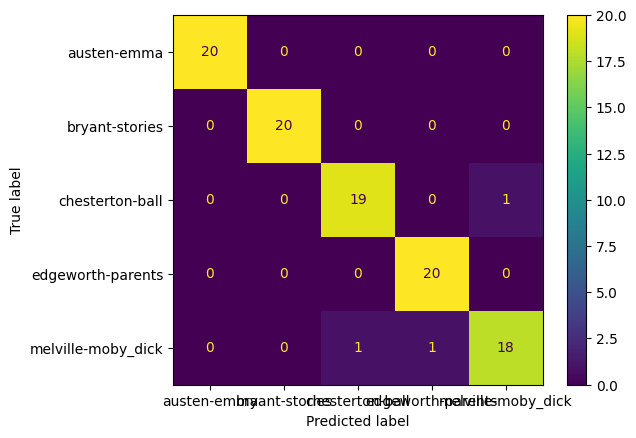

***************************************************************************************
training using BOW and SVM 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 97.0


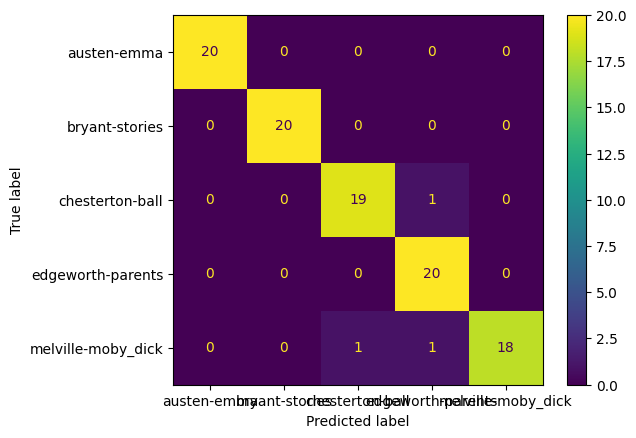

***************************************************************************************
training using BOW and Decision Tree 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 76.0


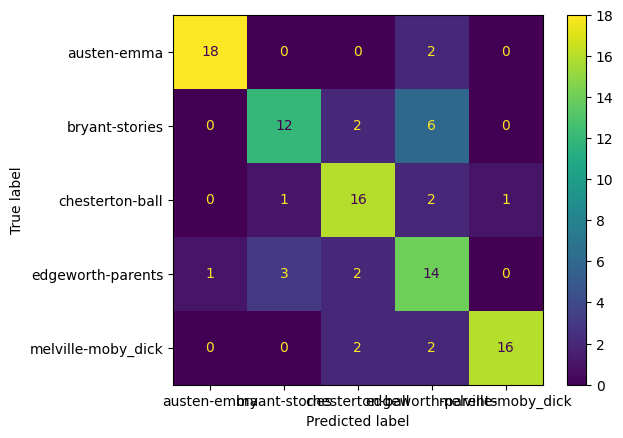

***************************************************************************************
training using BOW and RandomForest Classifier 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 94.0


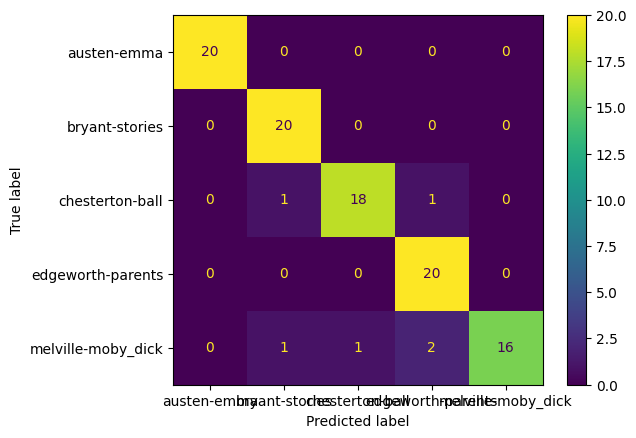

***************************************************************************************
training using BOW and GradientBoosting 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 93.0


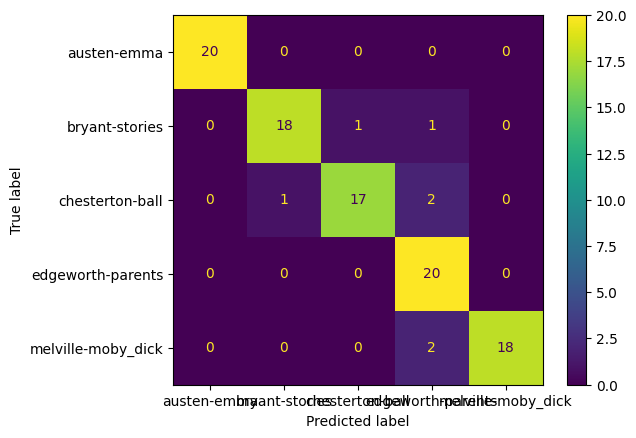

***************************************************************************************
training using BOW and k-Nearest Neighbor 
Don't apply Cross cross validation 
train accuracy: 93.375
validation accuracy: 85.0


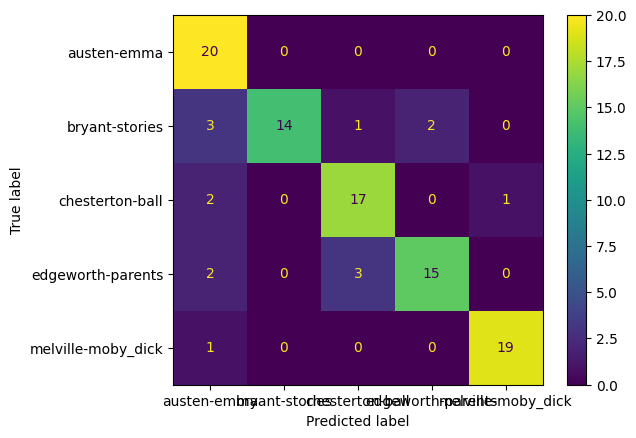

***************************************************************************************
training using BOW and naive base 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 96.0


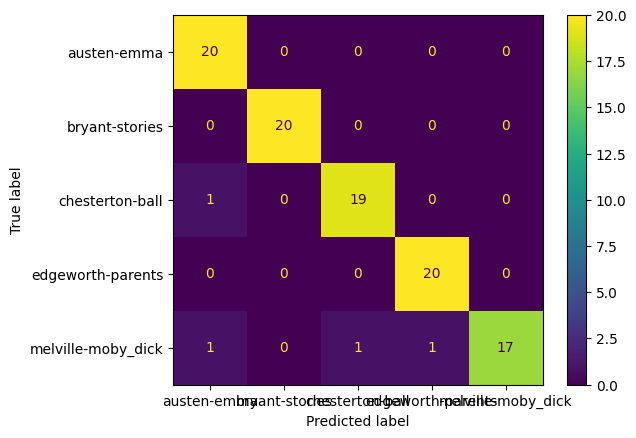

***************************************************************************************
training using TF-IDF and logistic regression 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 97.0


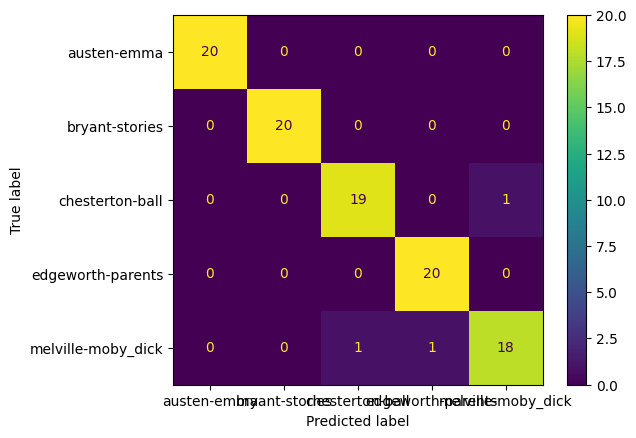

***************************************************************************************
training using TF-IDF and SVM 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 98.0


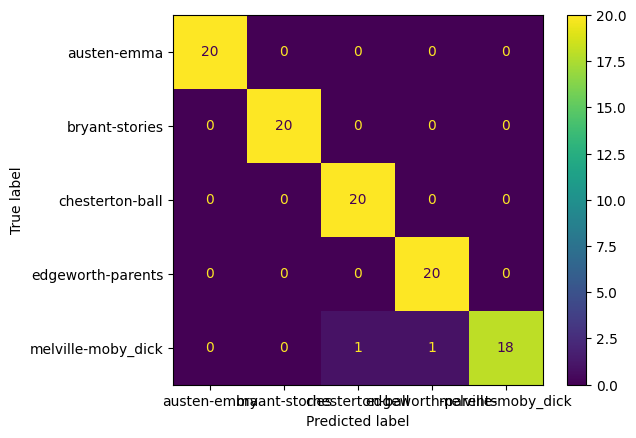

***************************************************************************************
training using TF-IDF and Decision Tree 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 80.0


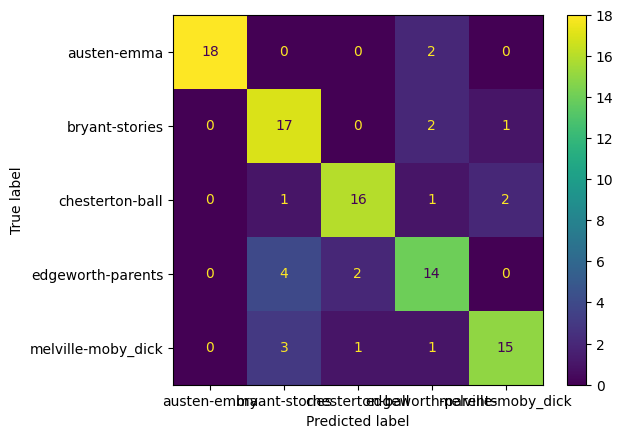

***************************************************************************************
training using TF-IDF and RandomForest Classifier 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 92.0


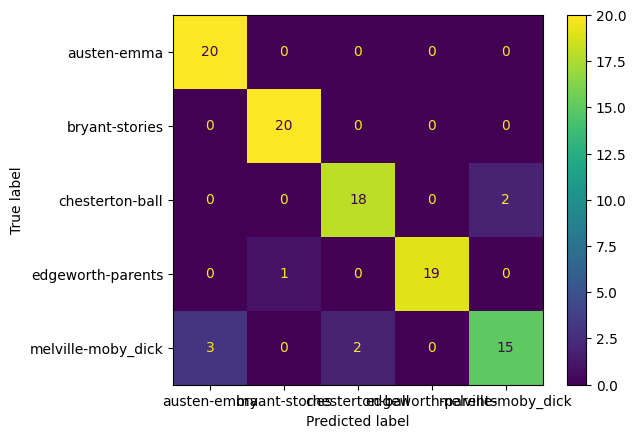

***************************************************************************************
training using TF-IDF and GradientBoosting 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 94.0


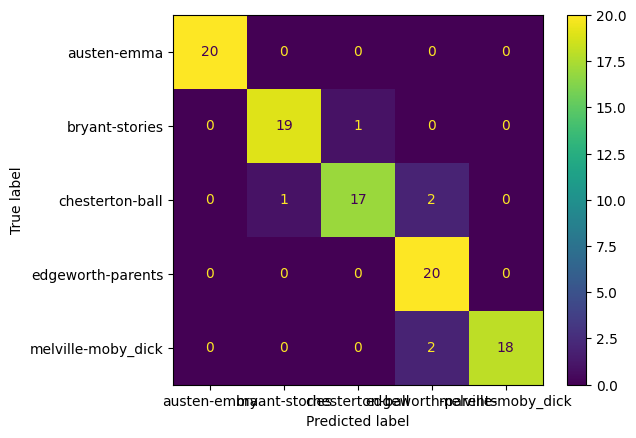

***************************************************************************************
training using TF-IDF and k-Nearest Neighbor 
Don't apply Cross cross validation 
train accuracy: 97.75
validation accuracy: 91.0


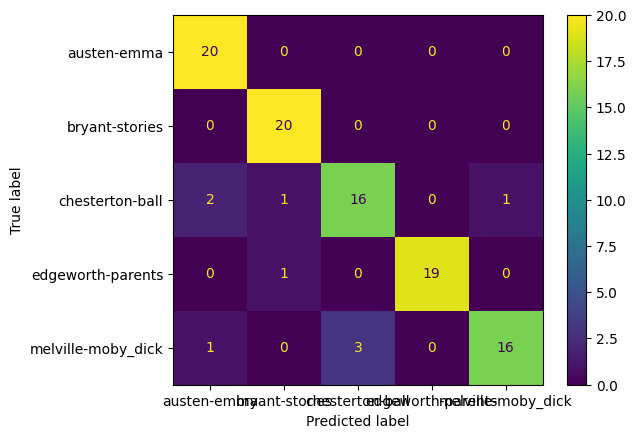

***************************************************************************************
training using TF-IDF and naive base 
Don't apply Cross cross validation 
train accuracy: 99.625
validation accuracy: 95.0


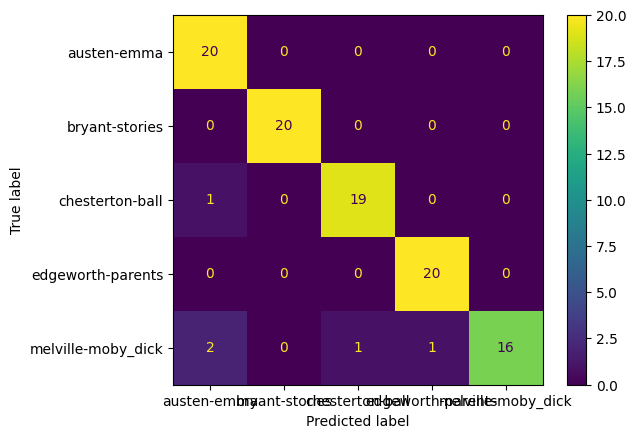

***************************************************************************************
training using n-gram and logistic regression 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 85.0


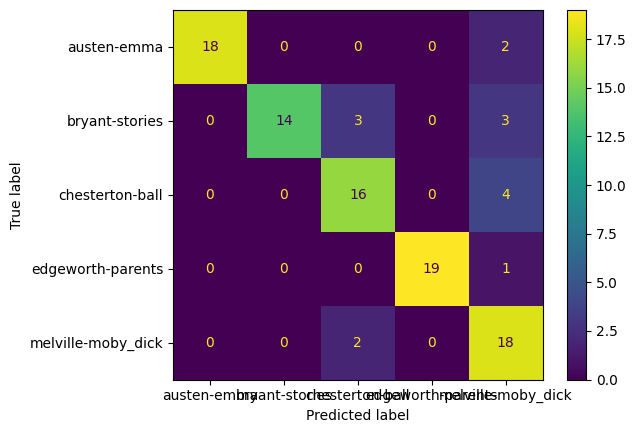

***************************************************************************************
training using n-gram and SVM 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 32.0


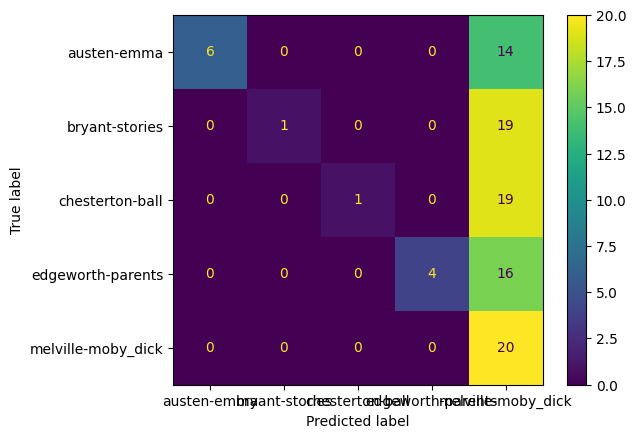

***************************************************************************************
training using n-gram and Decision Tree 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 67.0


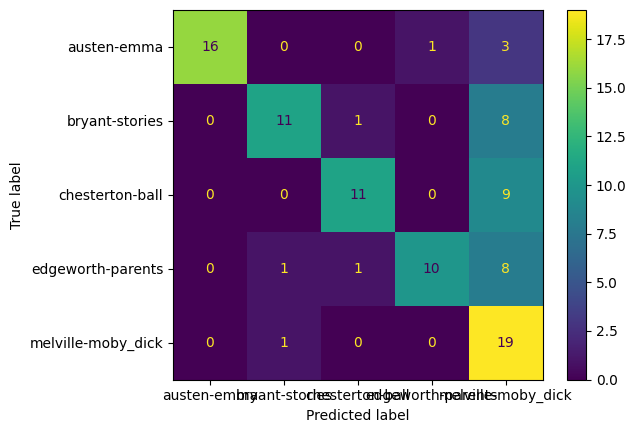

***************************************************************************************
training using n-gram and RandomForest Classifier 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 60.0


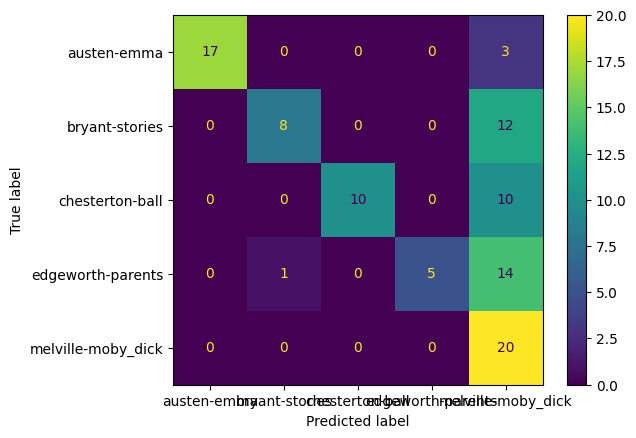

***************************************************************************************
training using n-gram and GradientBoosting 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 70.0


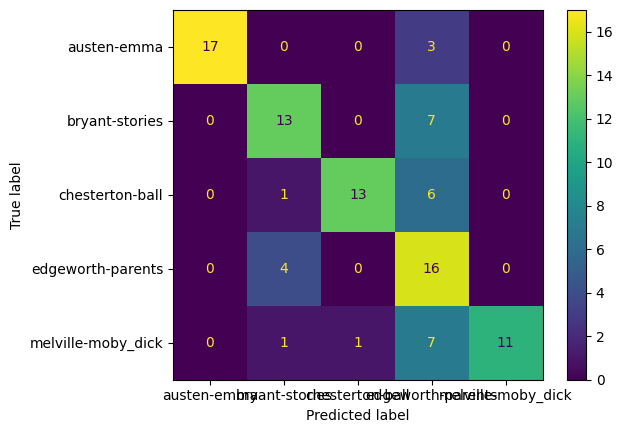

***************************************************************************************
training using n-gram and k-Nearest Neighbor 
Don't apply Cross cross validation 
train accuracy: 33.375
validation accuracy: 25.0


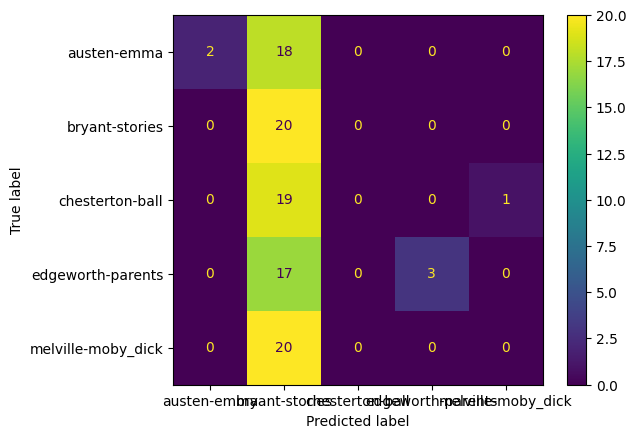

***************************************************************************************
training using n-gram and naive base 
Don't apply Cross cross validation 
train accuracy: 100.0
validation accuracy: 91.0


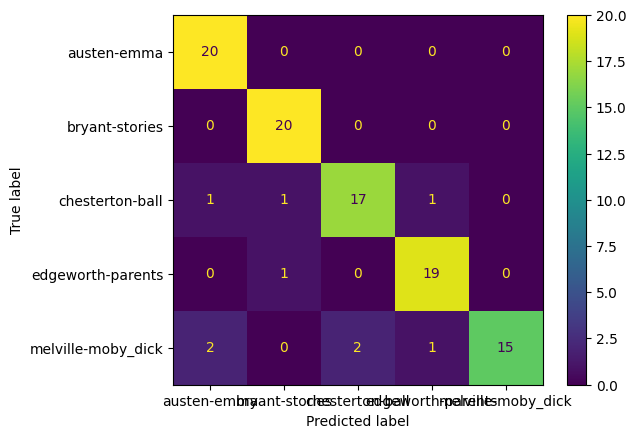

***************************************************************************************


In [ ]:
data,test_set,models=train(x,y,Features_Engneering_names,models_names,False)

<a id="11"></a> <br>
### Perform Evaluation on models that train without cross validation

Train Time Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[1.3626708984375, 0.9852797985076904, 0.08582448959350586, 0.672107458114624, 6.144625186920166, 0.002916097640991211, 0.015670299530029297, 0.700129508972168, 0.9711463451385498, 0.2721548080444336, 1.3412566184997559, 15.638564348220825, 0.0024700164794921875, 0.009668827056884766, 3.1182475090026855, 1.1666724681854248, 1.3260209560394287, 1.82983

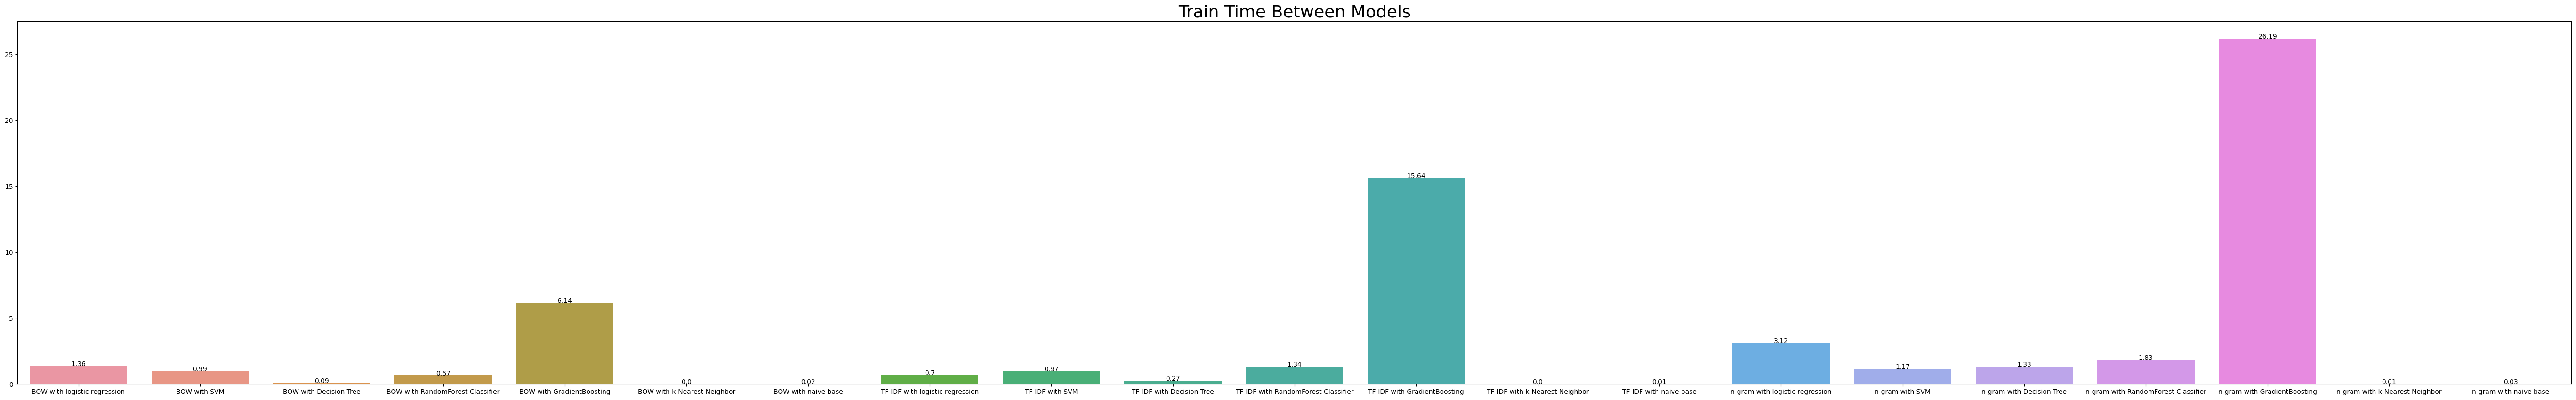

In [ ]:
plot_comp(data,0,'Train Time Between Models')

Train accuracy Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[100.0, 100.0, 100.0, 100.0, 100.0, 93.375, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 97.75, 99.625, 100.0, 100.0, 100.0, 100.0, 100.0, 33.375, 100.0]


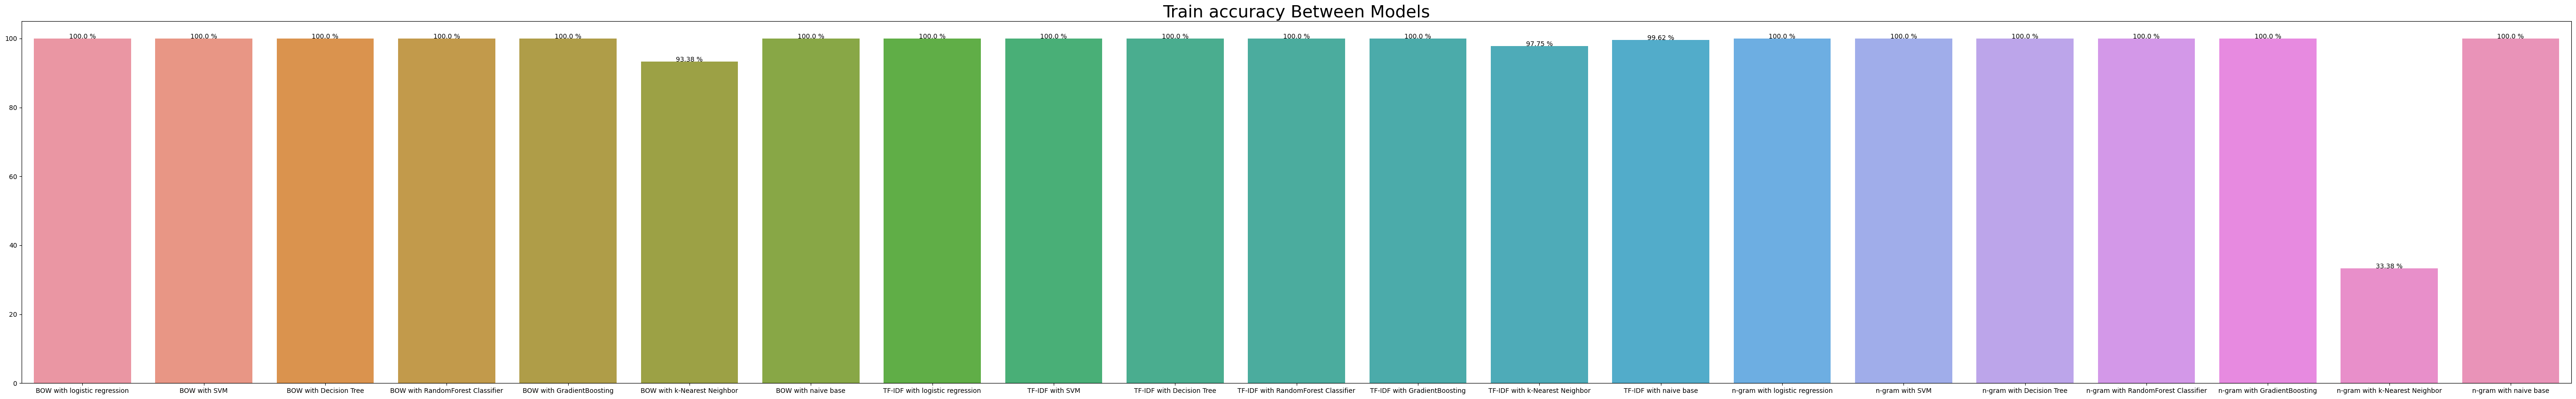

In [ ]:
plot_comp(data,1,'Train accuracy Between Models')

Validation accuracy Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[97.0, 97.0, 76.0, 94.0, 93.0, 85.0, 96.0, 97.0, 98.0, 80.0, 92.0, 94.0, 91.0, 95.0, 85.0, 32.0, 67.0, 60.0, 70.0, 25.0, 91.0]


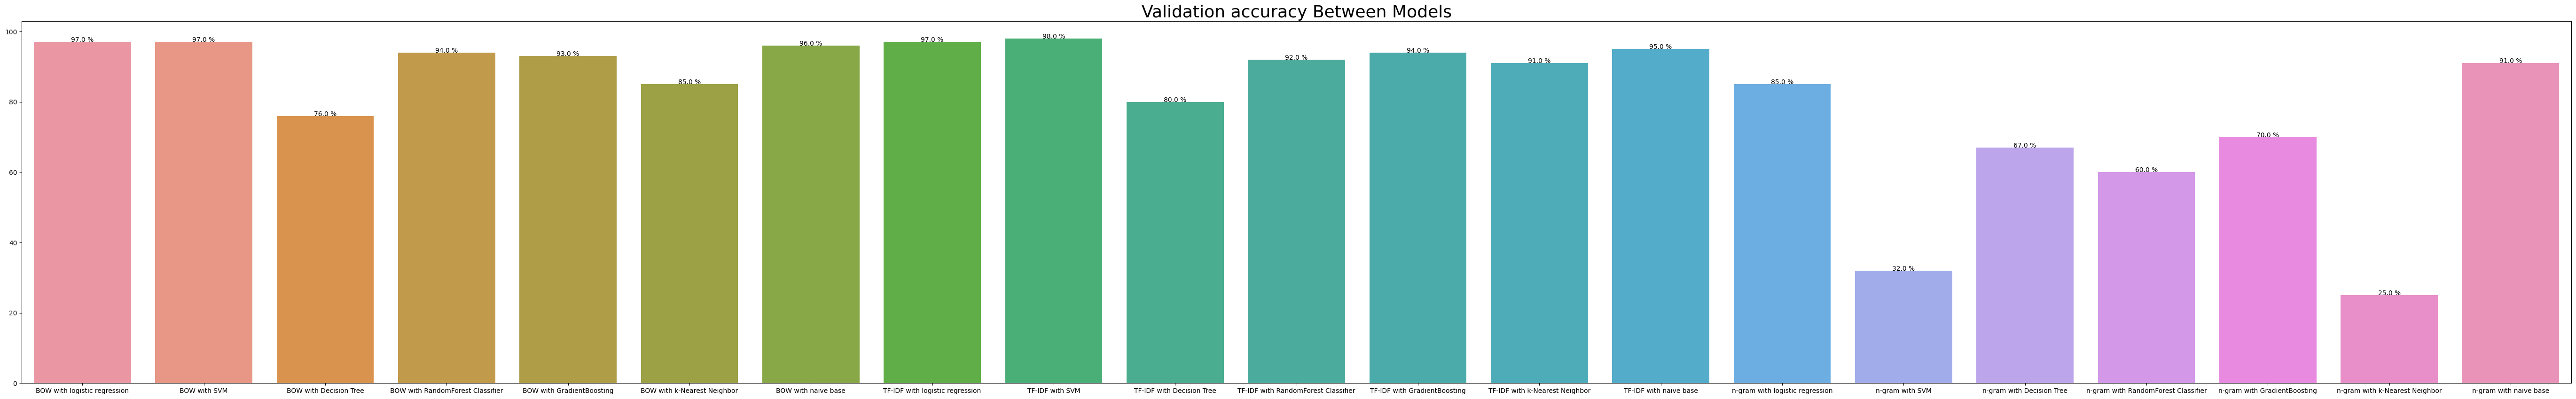

In [ ]:
plot_comp(data,2,'Validation accuracy Between Models')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


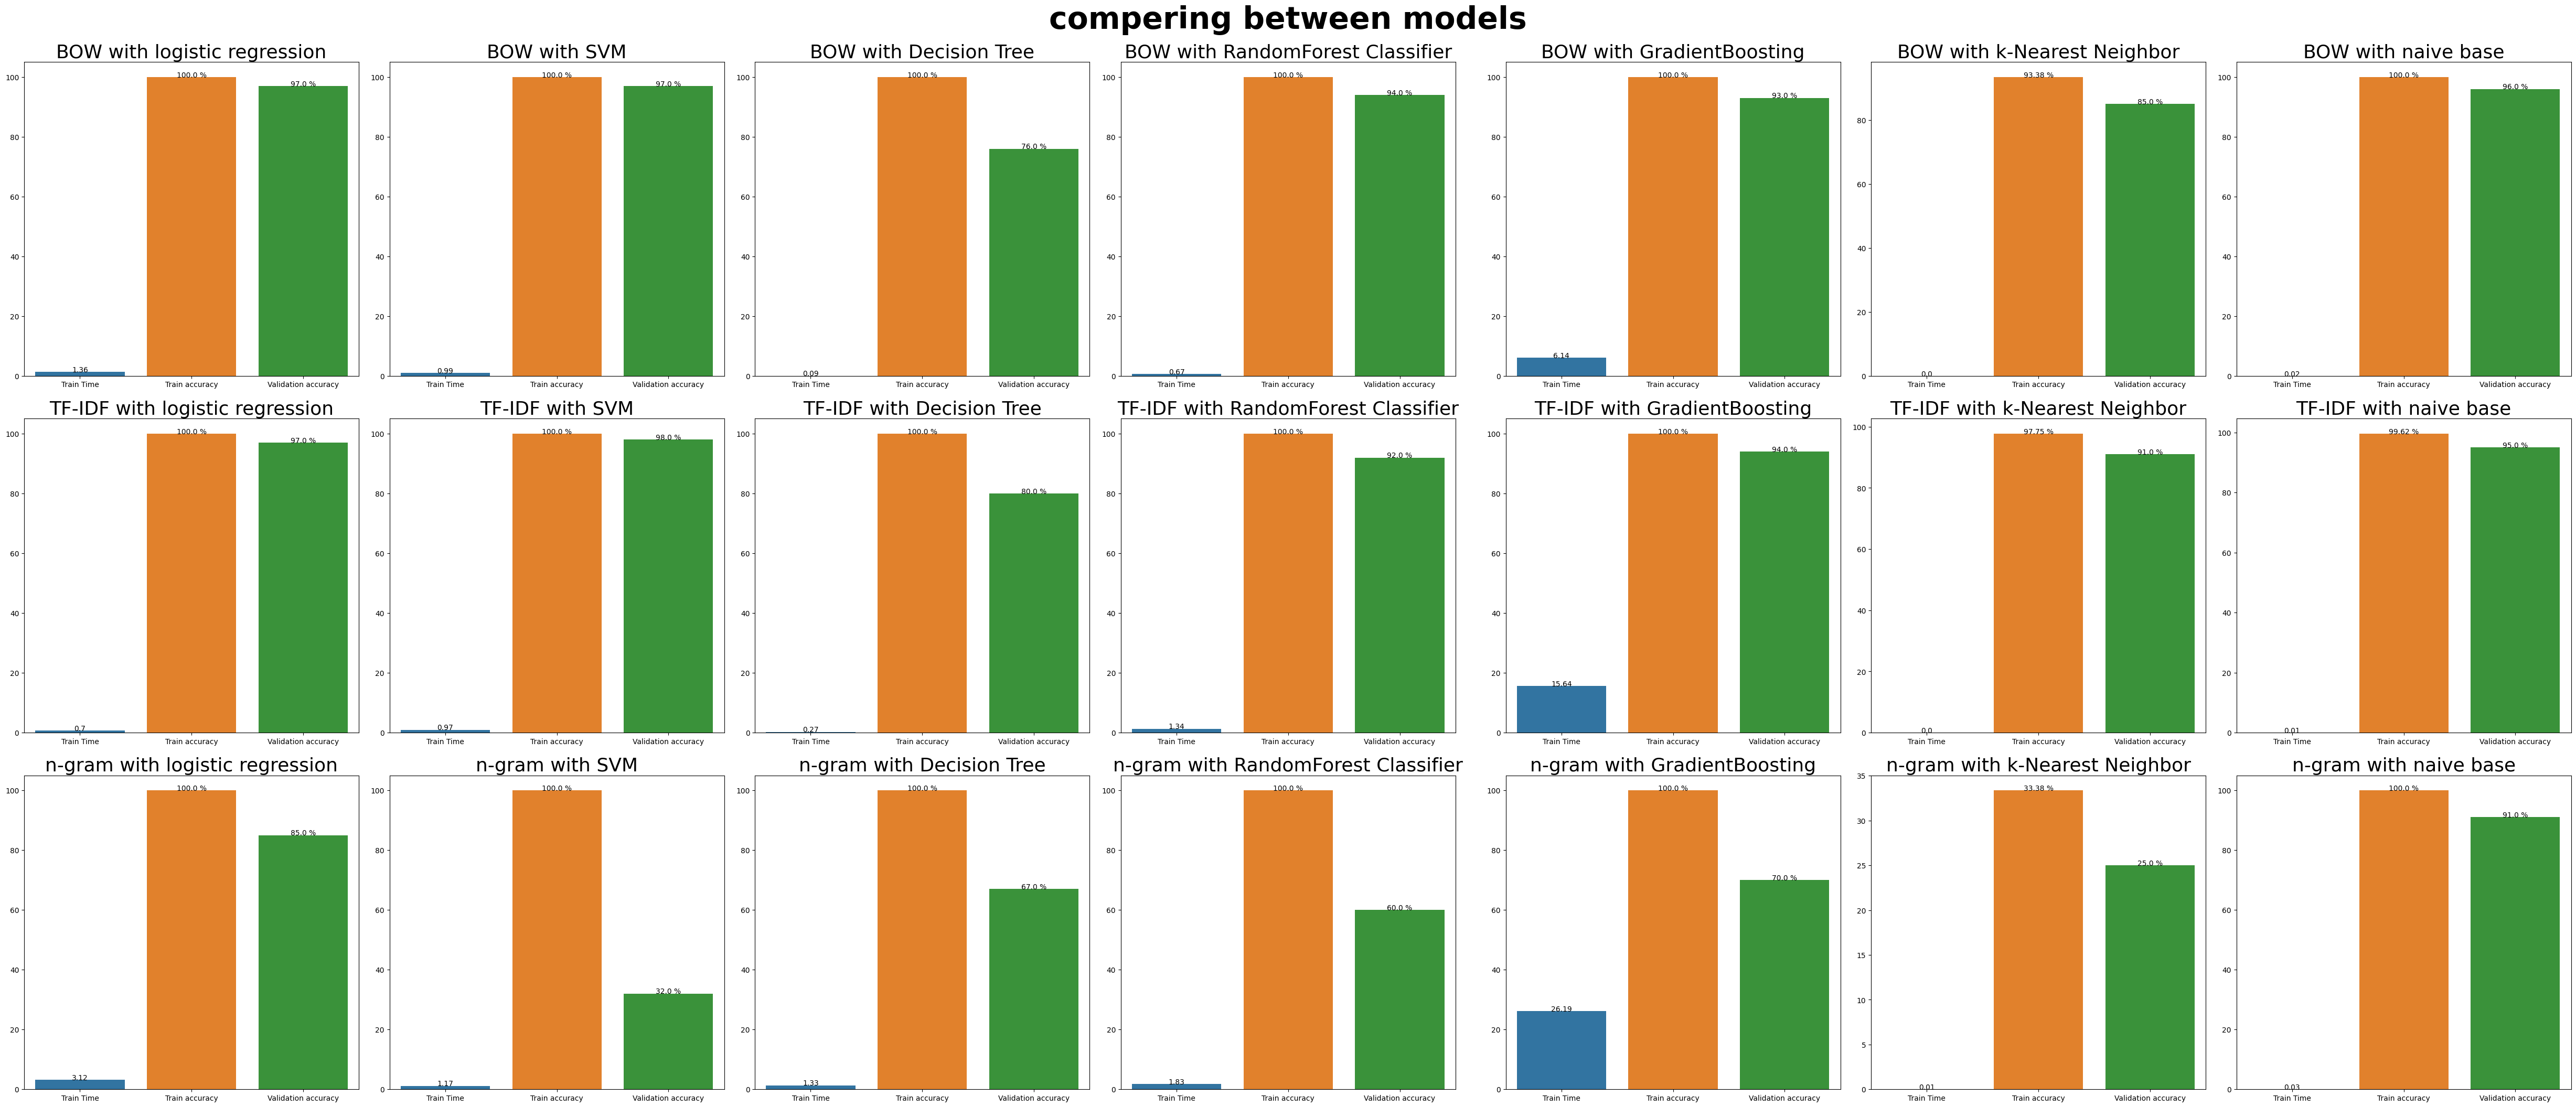

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
plotCompare(Features_Engneering_names,models_names,data,['Train Time','Train accuracy','Validation accuracy'])

<a id="12"></a> <br>
### train with cross validation

training using BOW and logistic regression 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 96.8888888888889
variance : 2.4241582476968264


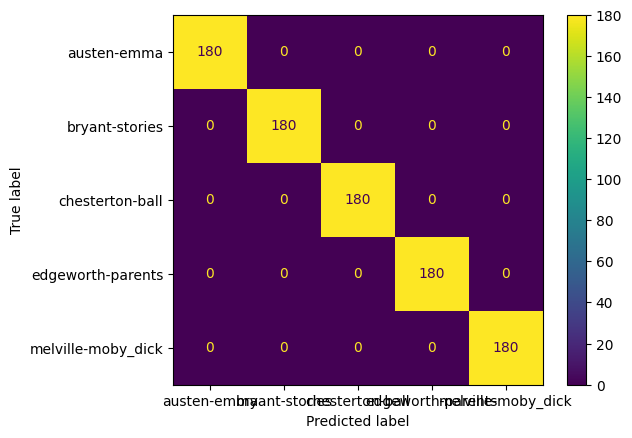

***************************************************************************************
training using BOW and SVM 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 94.77777777777779
variance : 2.168802366215903


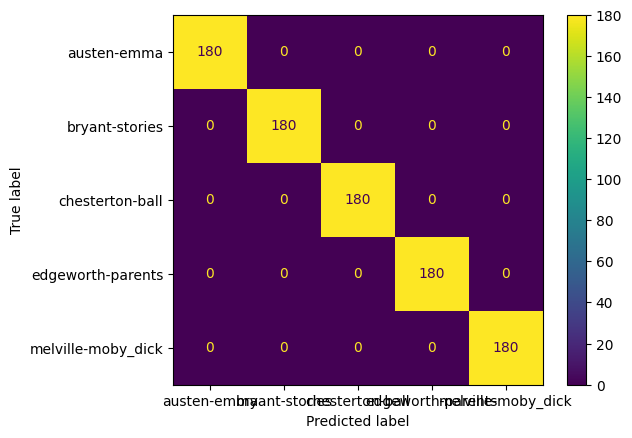

***************************************************************************************
training using BOW and Decision Tree 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 79.22222222222223
variance : 4.389943614475203


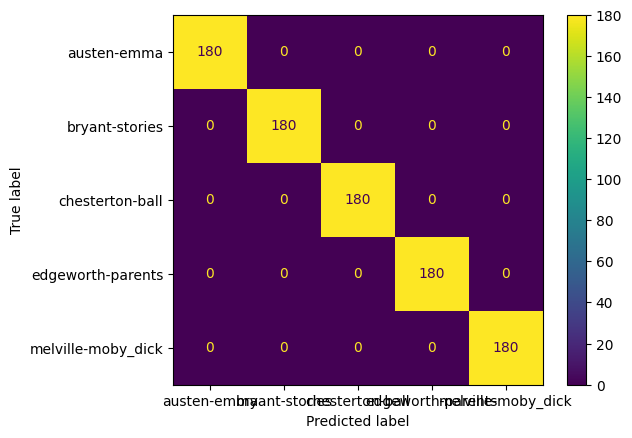

***************************************************************************************
training using BOW and RandomForest Classifier 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 93.55555555555556
variance : 3.055050463303895


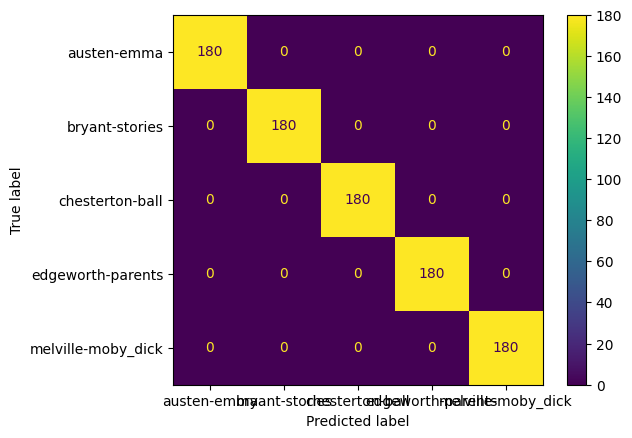

***************************************************************************************
training using BOW and GradientBoosting 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 92.22222222222221
variance : 2.8974232912011777


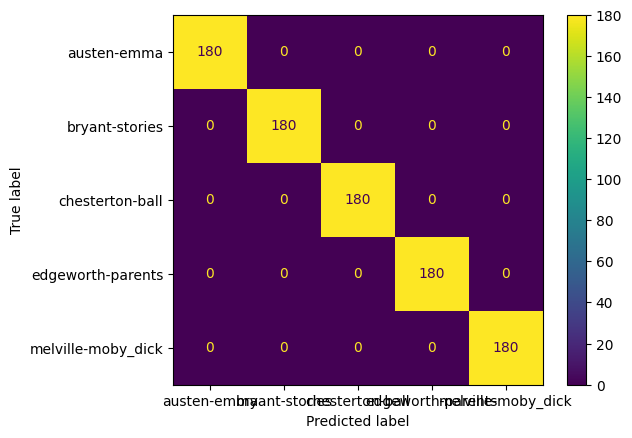

***************************************************************************************
training using BOW and k-Nearest Neighbor 
apply Cross cross validation with 10 fold .
train accuracy: 94.11111111111111
mean of accuracies: 85.0
variance : 2.950204010522612


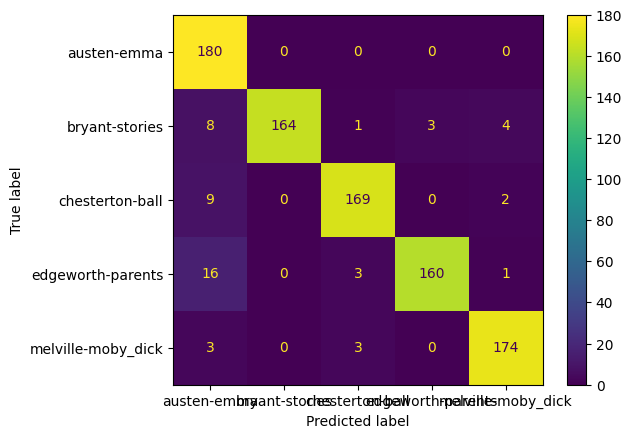

***************************************************************************************
training using BOW and naive base 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 97.77777777777779
variance : 2.1081851067789206


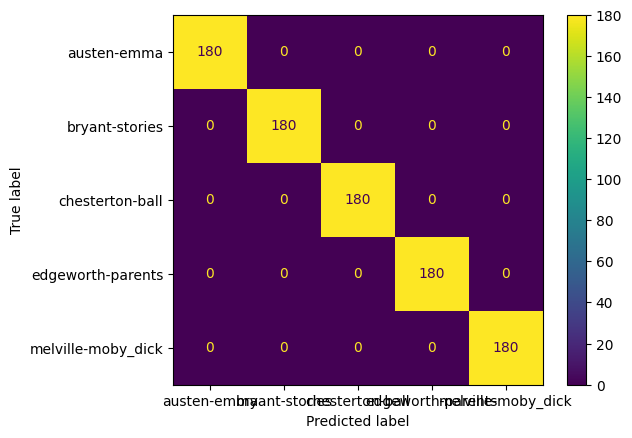

***************************************************************************************
training using TF-IDF and logistic regression 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 98.44444444444444
variance : 1.1331154474650642


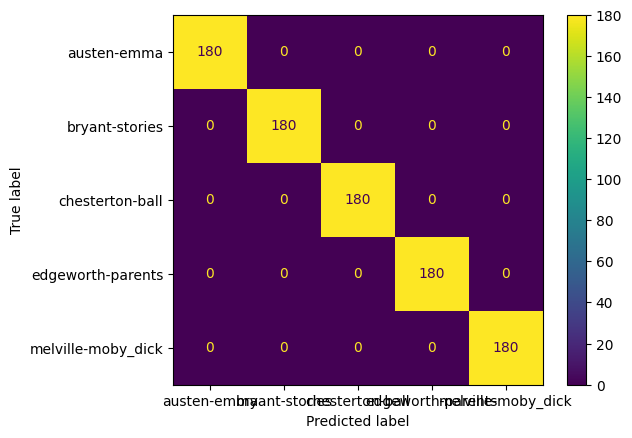

***************************************************************************************
training using TF-IDF and SVM 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 98.22222222222223
variance : 1.1331154474650642


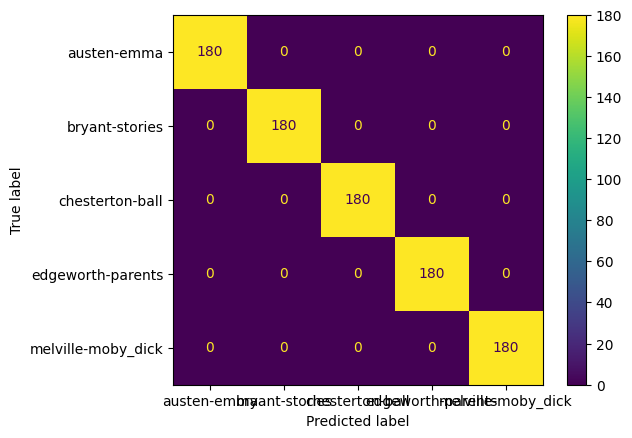

***************************************************************************************
training using TF-IDF and Decision Tree 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 77.22222222222223
variance : 2.5939150066508336


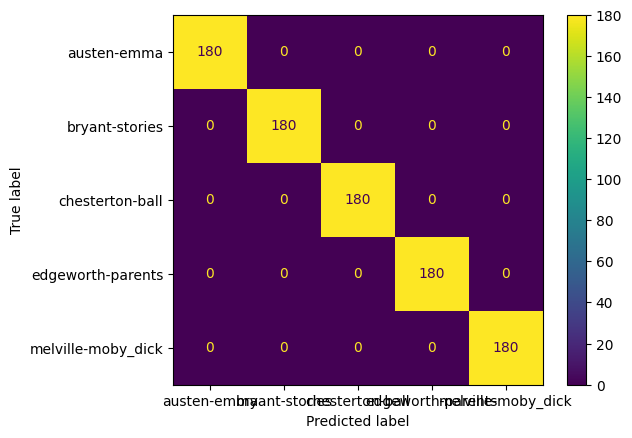

***************************************************************************************
training using TF-IDF and RandomForest Classifier 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 93.0
variance : 2.1111111111111116


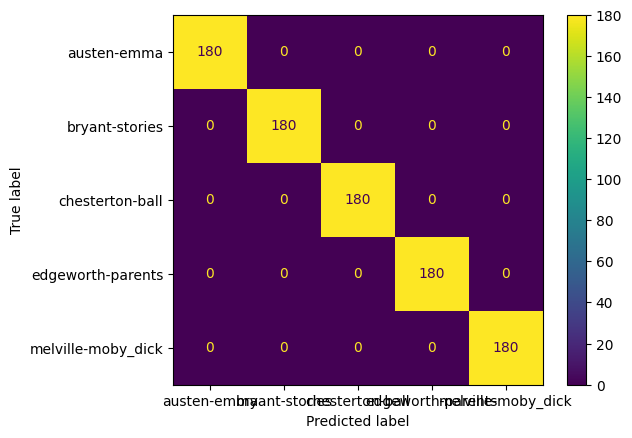

***************************************************************************************
training using TF-IDF and GradientBoosting 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 92.22222222222221
variance : 2.766644355108608


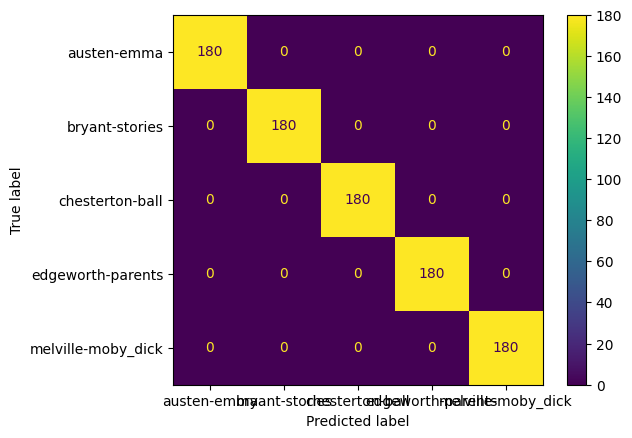

***************************************************************************************
training using TF-IDF and k-Nearest Neighbor 
apply Cross cross validation with 10 fold .
train accuracy: 97.66666666666667
mean of accuracies: 95.0
variance : 1.511274500970604


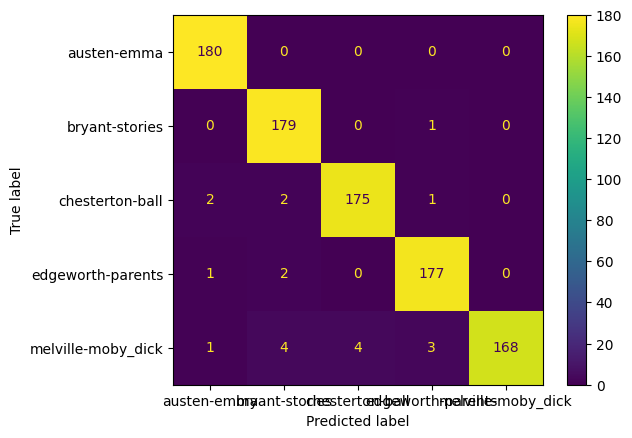

***************************************************************************************
training using TF-IDF and naive base 
apply Cross cross validation with 10 fold .
train accuracy: 99.66666666666667
mean of accuracies: 96.1111111111111
variance : 1.8087578440110785


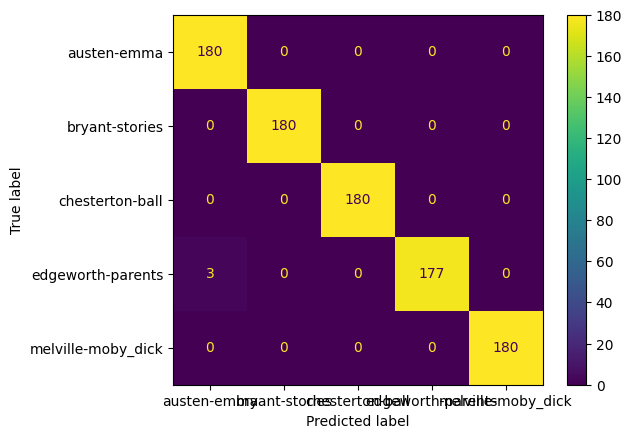

***************************************************************************************
training using n-gram and logistic regression 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 90.88888888888889
variance : 2.4241582476968246


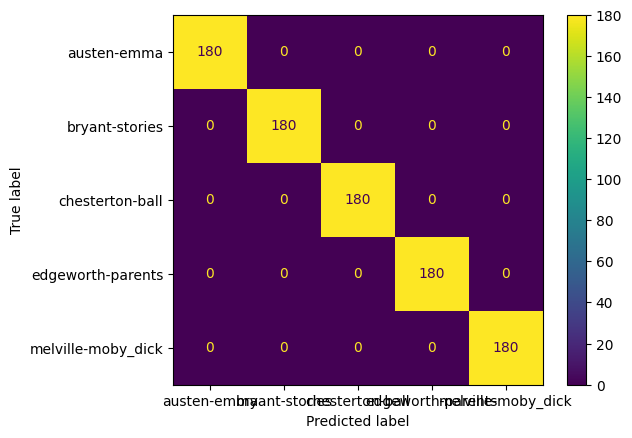

***************************************************************************************
training using n-gram and SVM 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 67.44444444444446
variance : 6.795968303721348


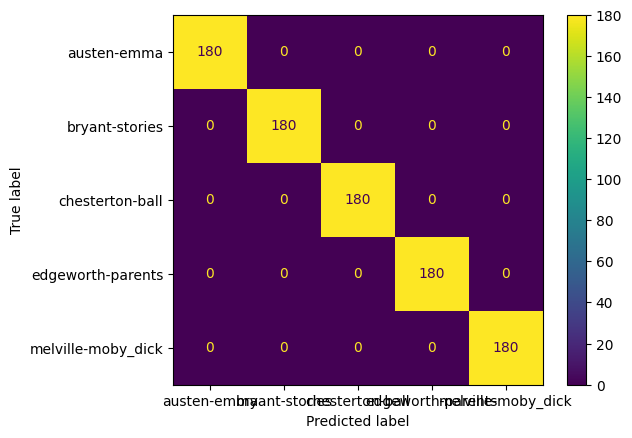

***************************************************************************************
training using n-gram and Decision Tree 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 63.22222222222222
variance : 2.650413431528124


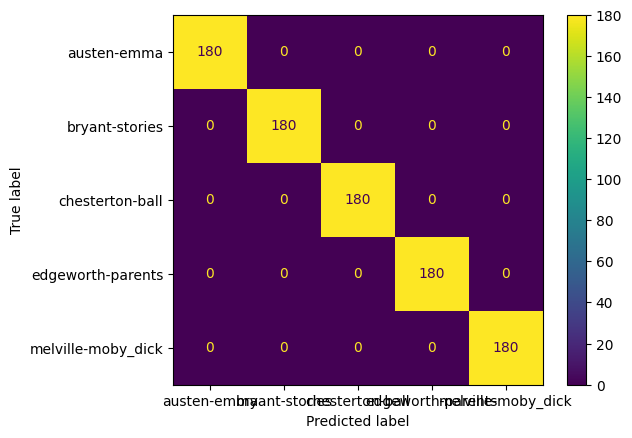

***************************************************************************************
training using n-gram and RandomForest Classifier 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 57.99999999999999
variance : 4.091545031004883


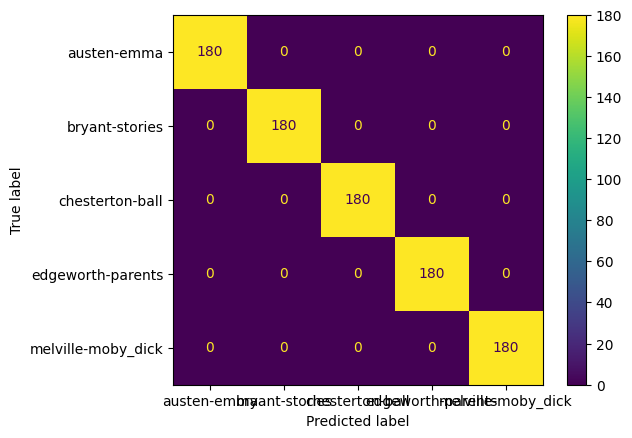

***************************************************************************************
training using n-gram and GradientBoosting 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 68.77777777777779
variance : 4.258615088163731


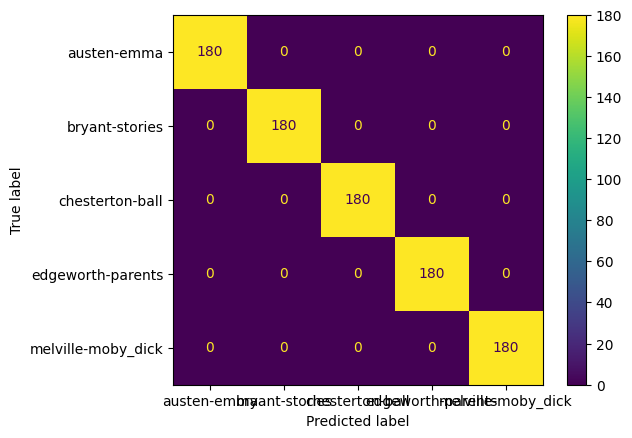

***************************************************************************************
training using n-gram and k-Nearest Neighbor 
apply Cross cross validation with 10 fold .
train accuracy: 48.22222222222222
mean of accuracies: 28.777777777777775
variance : 3.831319922125927


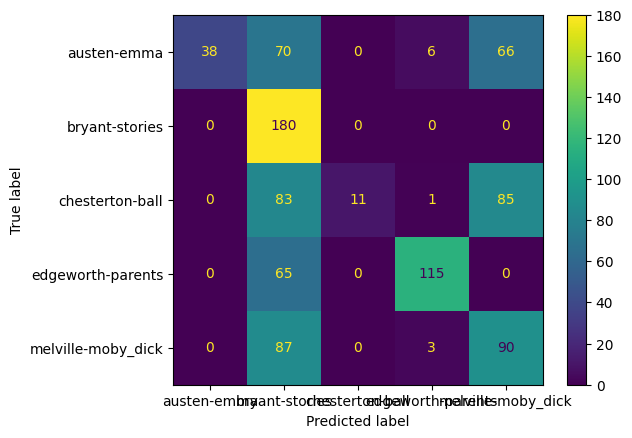

***************************************************************************************
training using n-gram and naive base 
apply Cross cross validation with 10 fold .
train accuracy: 100.0
mean of accuracies: 90.0
variance : 3.1426968052735447


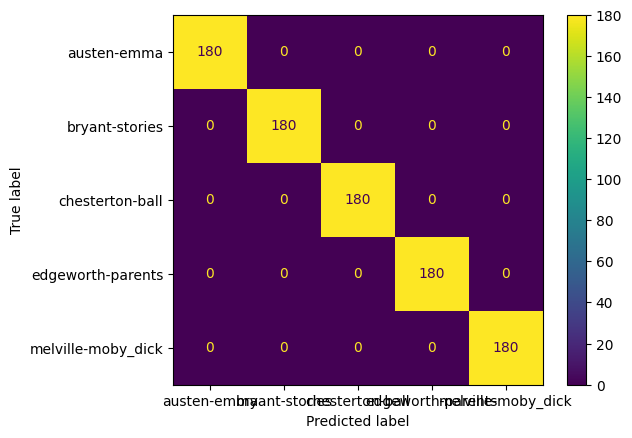

***************************************************************************************


In [ ]:
data,test_set,models=train(x,y,Features_Engneering_names,models_names,True)

<a id="13"></a> <br>
### Perform Evaluation on models that train without cross validation

Train Time Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[43.09759736061096, 20.744436025619507, 0.9838457107543945, 8.064844608306885, 89.32926154136658, 0.18094778060913086, 0.10555243492126465, 8.434621572494507, 11.945011377334595, 1.2740097045898438, 8.284635782241821, 142.27740907669067, 0.17833304405212402, 0.1159670352935791, 32.6484854221344, 13.794555187225342, 15.073091268539429, 42.852826356887

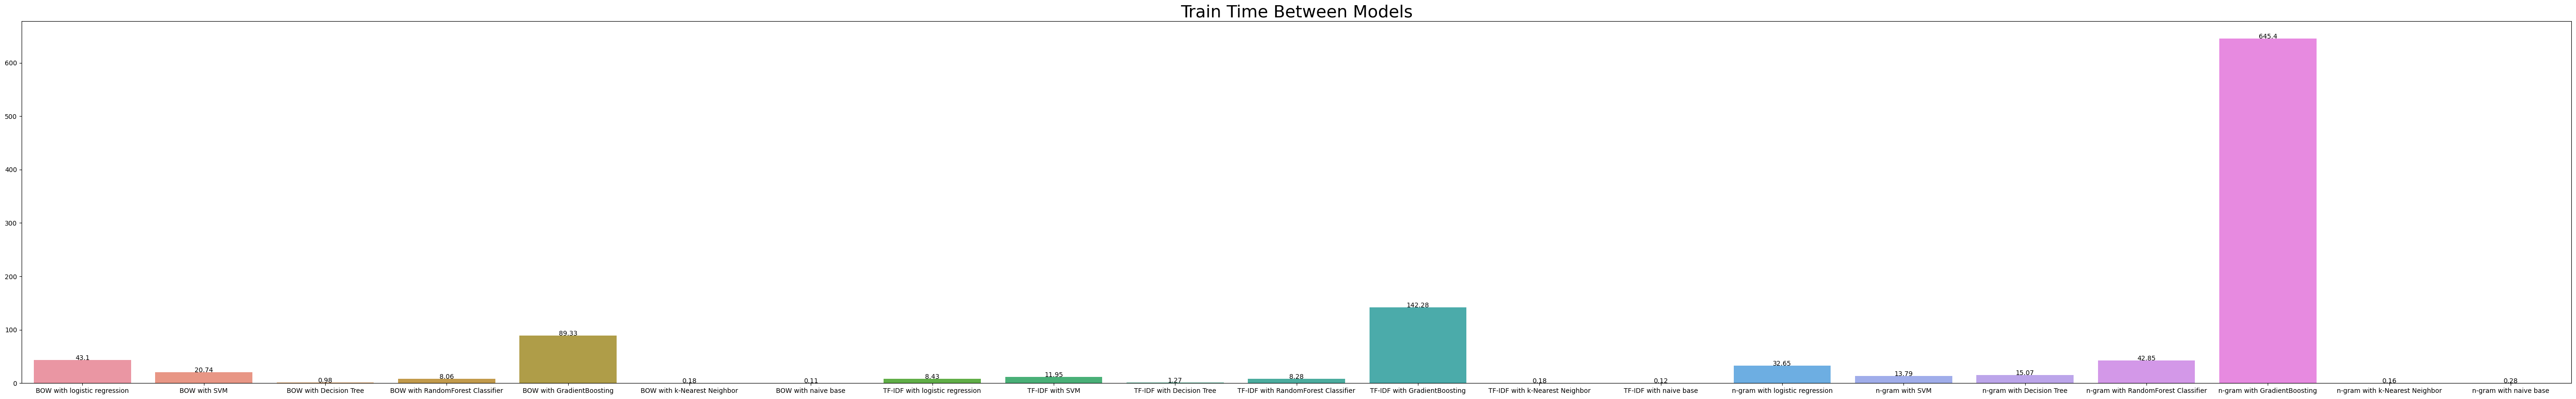

In [ ]:
plot_comp(data,0,'Train Time Between Models')

Train accuracy Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[100.0, 100.0, 100.0, 100.0, 100.0, 94.11111111111111, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 97.66666666666667, 99.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 48.22222222222222, 100.0]


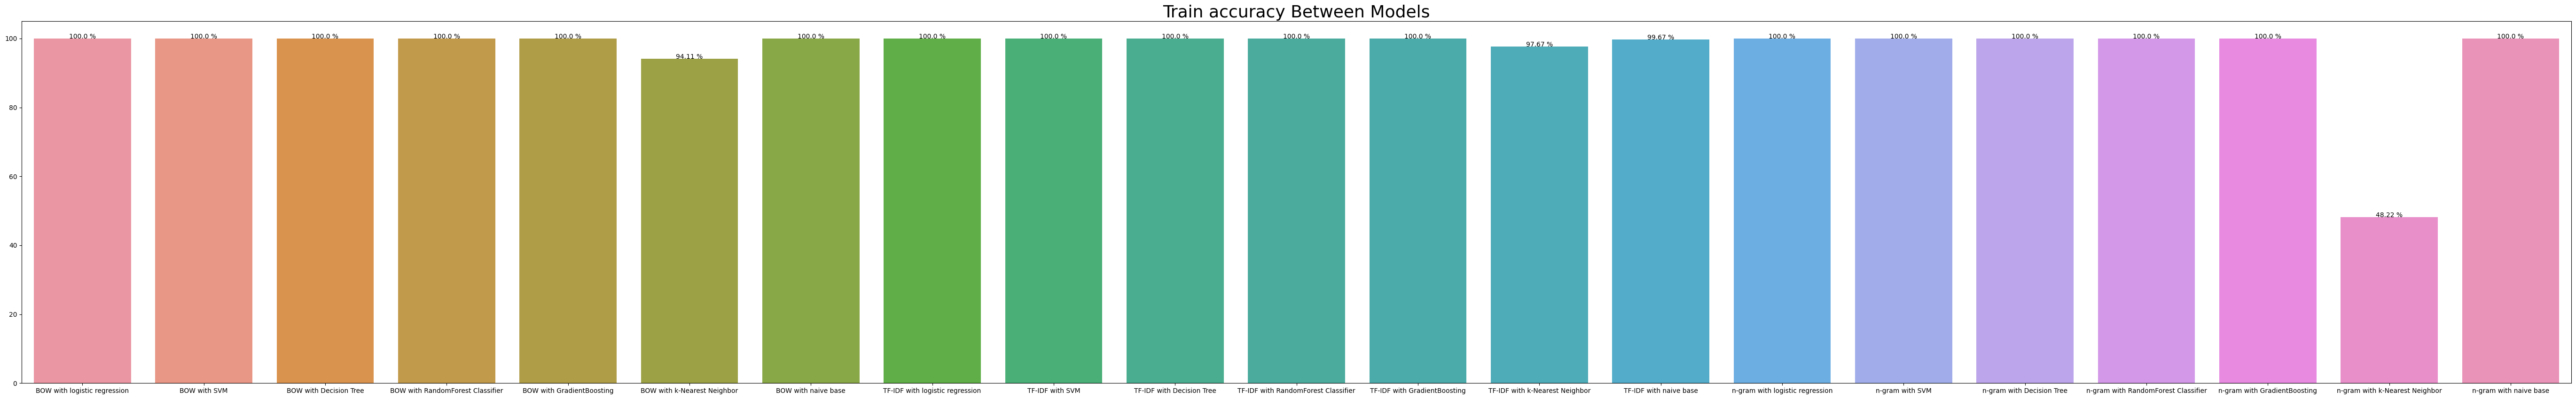

In [ ]:
plot_comp(data,1,'Train accuracy Between Models')

Validation accuracy Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[96.8888888888889, 94.77777777777779, 79.22222222222223, 93.55555555555556, 92.22222222222221, 85.0, 97.77777777777779, 98.44444444444444, 98.22222222222223, 77.22222222222223, 93.0, 92.22222222222221, 95.0, 96.1111111111111, 90.88888888888889, 67.44444444444446, 63.22222222222222, 57.99999999999999, 68.77777777777779, 28.777777777777775, 90

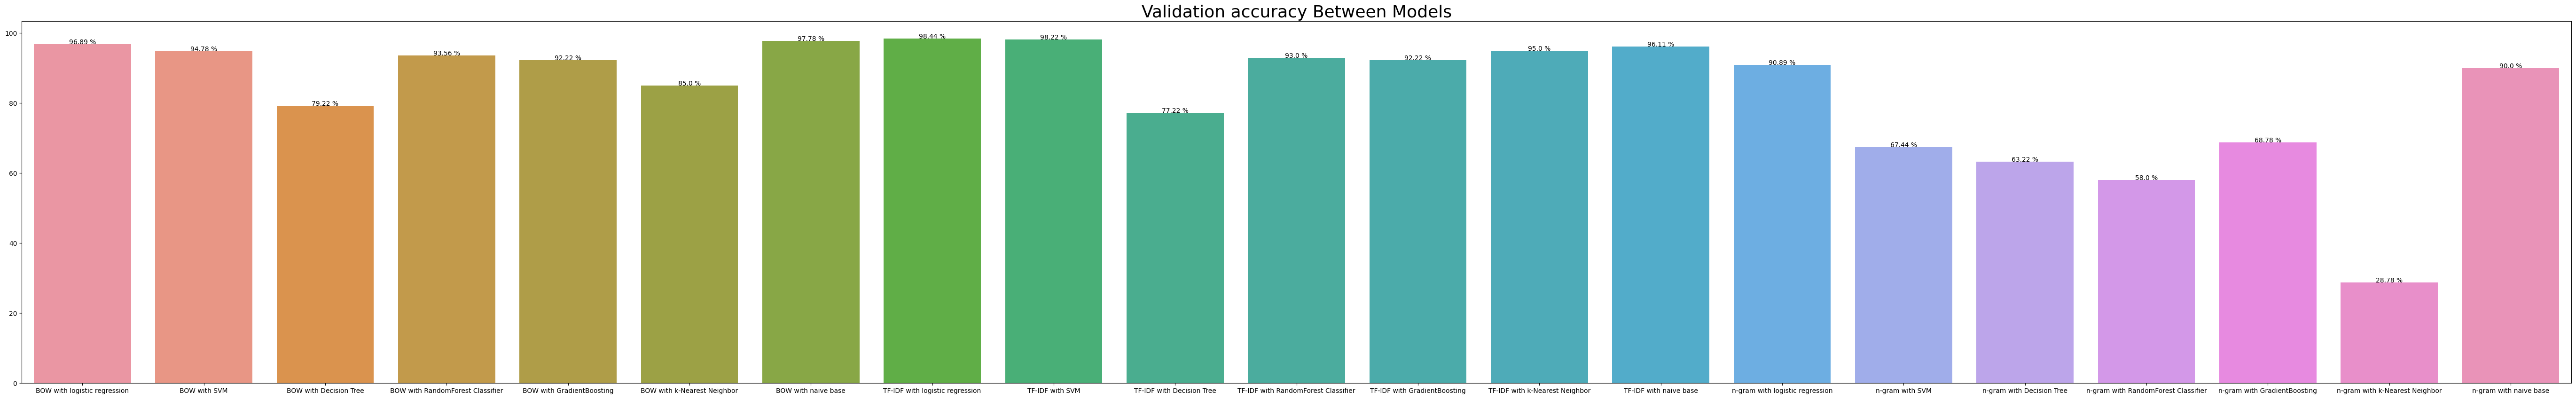

In [ ]:
plot_comp(data,2,'Validation accuracy Between Models')

mean variance Between Models
['BOW with logistic regression', 'BOW with SVM', 'BOW with Decision Tree', 'BOW with RandomForest Classifier', 'BOW with GradientBoosting', 'BOW with k-Nearest Neighbor', 'BOW with naive base', 'TF-IDF with logistic regression', 'TF-IDF with SVM', 'TF-IDF with Decision Tree', 'TF-IDF with RandomForest Classifier', 'TF-IDF with GradientBoosting', 'TF-IDF with k-Nearest Neighbor', 'TF-IDF with naive base', 'n-gram with logistic regression', 'n-gram with SVM', 'n-gram with Decision Tree', 'n-gram with RandomForest Classifier', 'n-gram with GradientBoosting', 'n-gram with k-Nearest Neighbor', 'n-gram with naive base']
[2.4241582476968264, 2.168802366215903, 4.389943614475203, 3.055050463303895, 2.8974232912011777, 2.950204010522612, 2.1081851067789206, 1.1331154474650642, 1.1331154474650642, 2.5939150066508336, 2.1111111111111116, 2.766644355108608, 1.511274500970604, 1.8087578440110785, 2.4241582476968246, 6.795968303721348, 2.650413431528124, 4.09154503100488

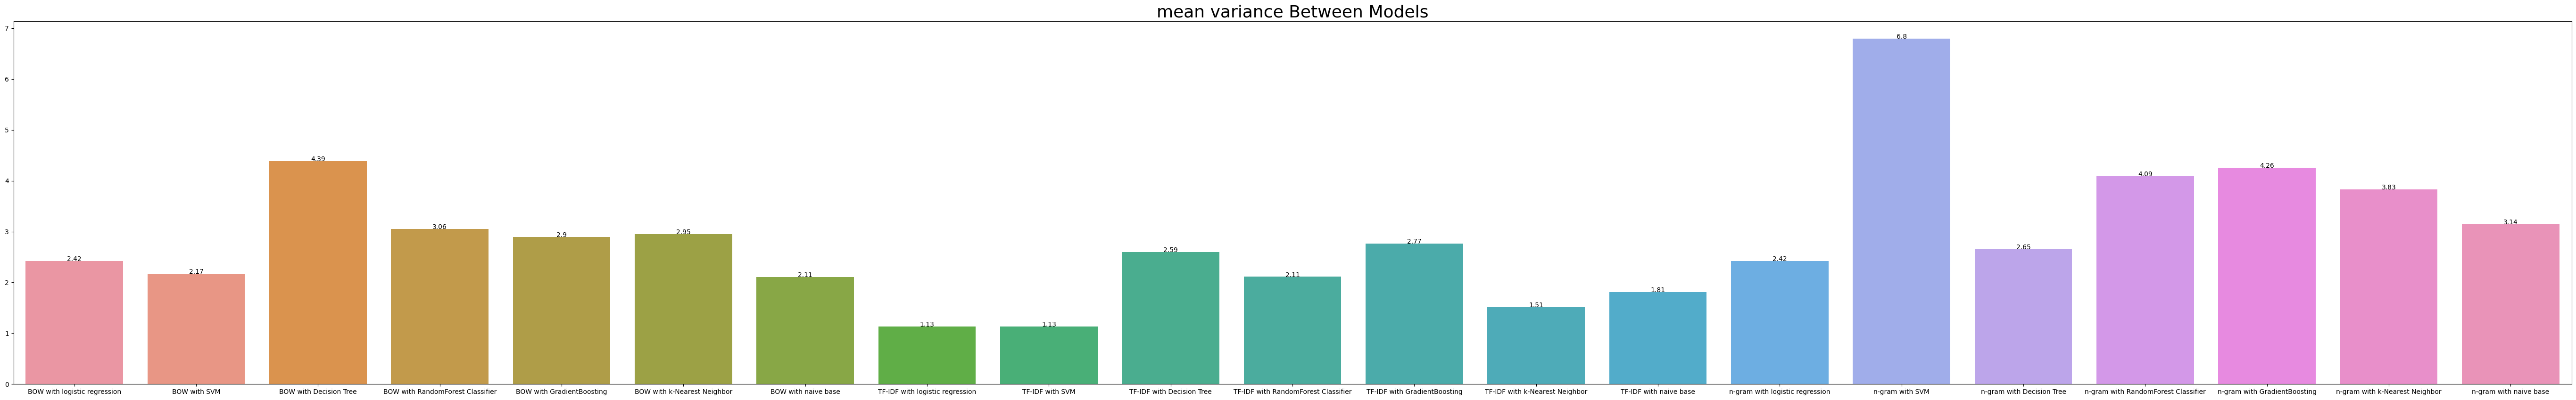

In [ ]:
plot_comp(data,3,'mean variance Between Models')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


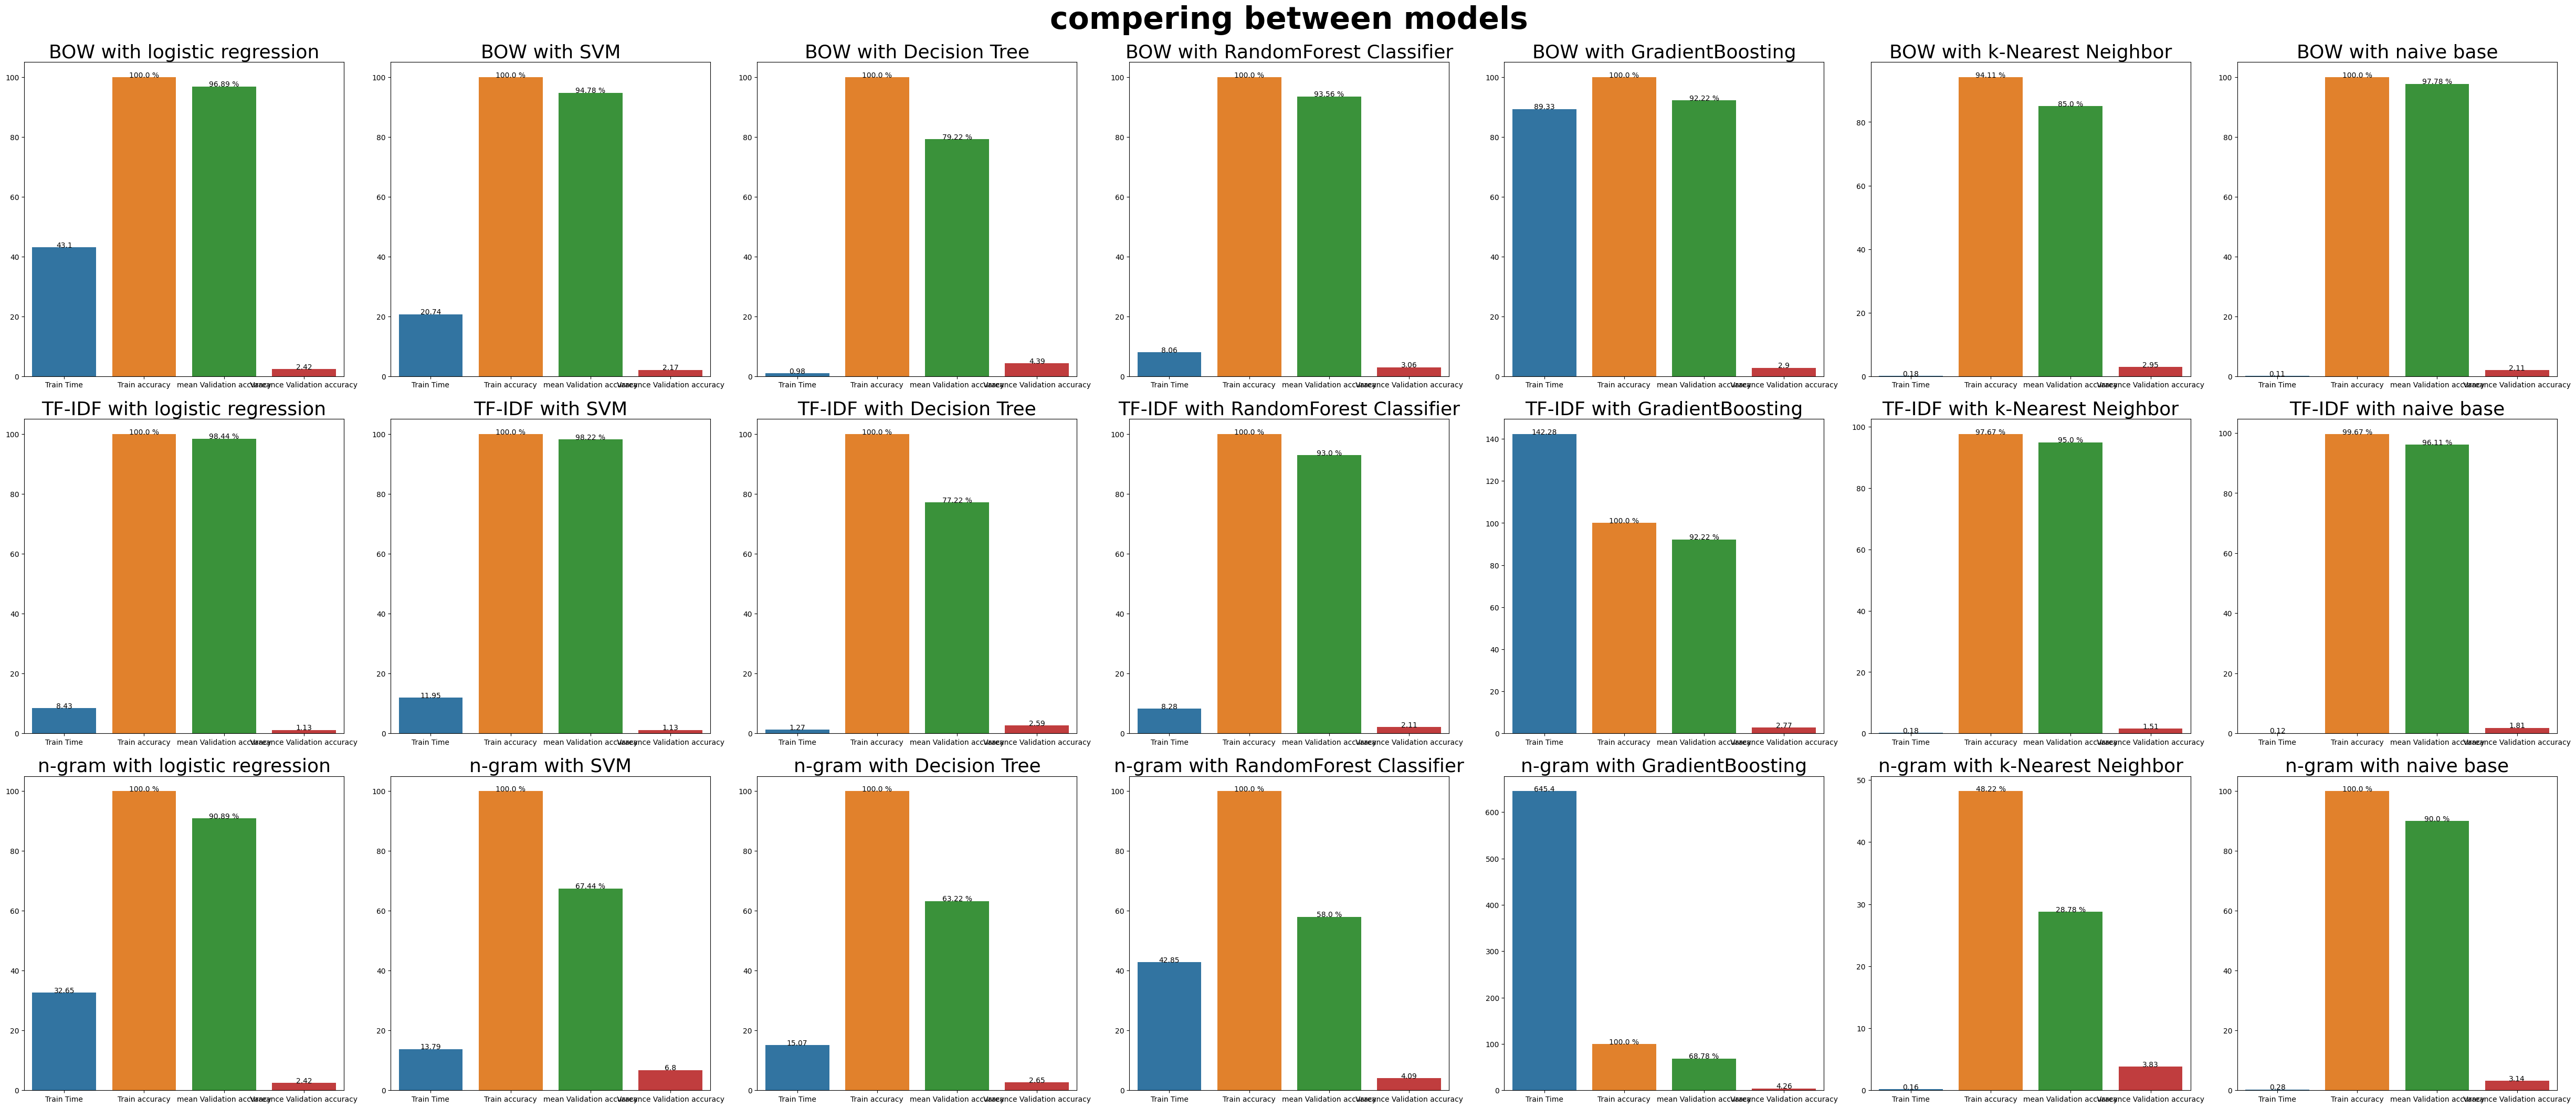

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
plotCompare(Features_Engneering_names,models_names,data,['Train Time','Train accuracy','mean Validation accuracy','Vareance Validation accuracy'])

<hr style="border: solid 3px Brown;">
<a id="14"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Compare and decide which algorithm is performing as the champion model </span></center>

<a id="15"></a> <br>
### get champion model 

In [ ]:
def printWrongPoints(X_test,y_test,y_pred,labels,courpus):
    """print the Wrong partitions of predictions
    Input: model, X_test, y_test, y_pred
    Output: print the Wrong partitions of prediction
    """
    wrongPoints = []
    wrongPointsIndex = []
    
    for index, val in enumerate(X_test):
        if y_pred[index] !=y_test[index]:
            pred_wrong=(courpus.inverse_transform(val))        
            
            text = " ".join(str(v) for v in pred_wrong)
            # Creating word_cloud with text as argument in .generate() method
            wc = WordCloud(collocations = False, background_color = 'white').generate(text)
            # Display the generated Word Cloud
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            wrongPoints.append(pred_wrong)
            wrongPointsIndex.append(y_pred[index])
       
    
    booksDataframeResult = pd.DataFrame(data=pd.Series(data=wrongPoints),columns=['Partitions' ]) 
     
    for i in range(len(labels)):
        booksDataframeResult[labels[i]]= [np.full(len(wrongPoints), [' '],dtype=str)][0] 
    

    classesWrongPredictionCounts=np.zeros(len(labels),dtype =int)
    print(classesWrongPredictionCounts)
    for index, val in enumerate(wrongPoints):
        booksDataframeResult.at[index,wrongPointsIndex[index]]='--X--'

   
     
    
    print("\n\n******\n\nWrong Predictions\n\n")
    display(booksDataframeResult)

    return booksDataframeResult

In [ ]:
def Test_Model(model,X_test,y_test,labels,courpus):
    """
    Function : Test_Model
    Used to test the model by label test set
    ---------------------------------
    Input : model, X_test set ,y_test set
    ---------------------------------
    Output : print the model accuracy and the visualization of wrong and correct point and the most partition that has 
    wrong class prediction
    """
    
     
    #test model by test data and get the predict labeles
    y_pred = model.predict(X_test)
  
    #print confusion matrix
    ConfusionMatrixDisplay.from_estimator(model,X_test, y_test)  
    plt.show()
    #print the accuracy of the model
    print('Accuracy of model: {:.2f}%'.format(model.score(X_test,y_test)*100)) 

    #print wrong prediction partitions
    printWrongPoints(X_test,y_test,y_pred,labels,courpus)
     

In [ ]:
def get_champion_model(results):
  f=True
  for key,value in results.items():
    if f:
      best=key
      f=False
    if value[2]>=results[best][2]:
      if value[3]<=results[best][3]:
        best=key
  return best

In [ ]:
champion=get_champion_model(data)
champions=champion.split(' with ')
print(champion)
print(champions)


TF-IDF with logistic regression
['TF-IDF', 'logistic regression']


<hr style="border: solid 3px Brown;">
<a id="16"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Error analysis </span></center>

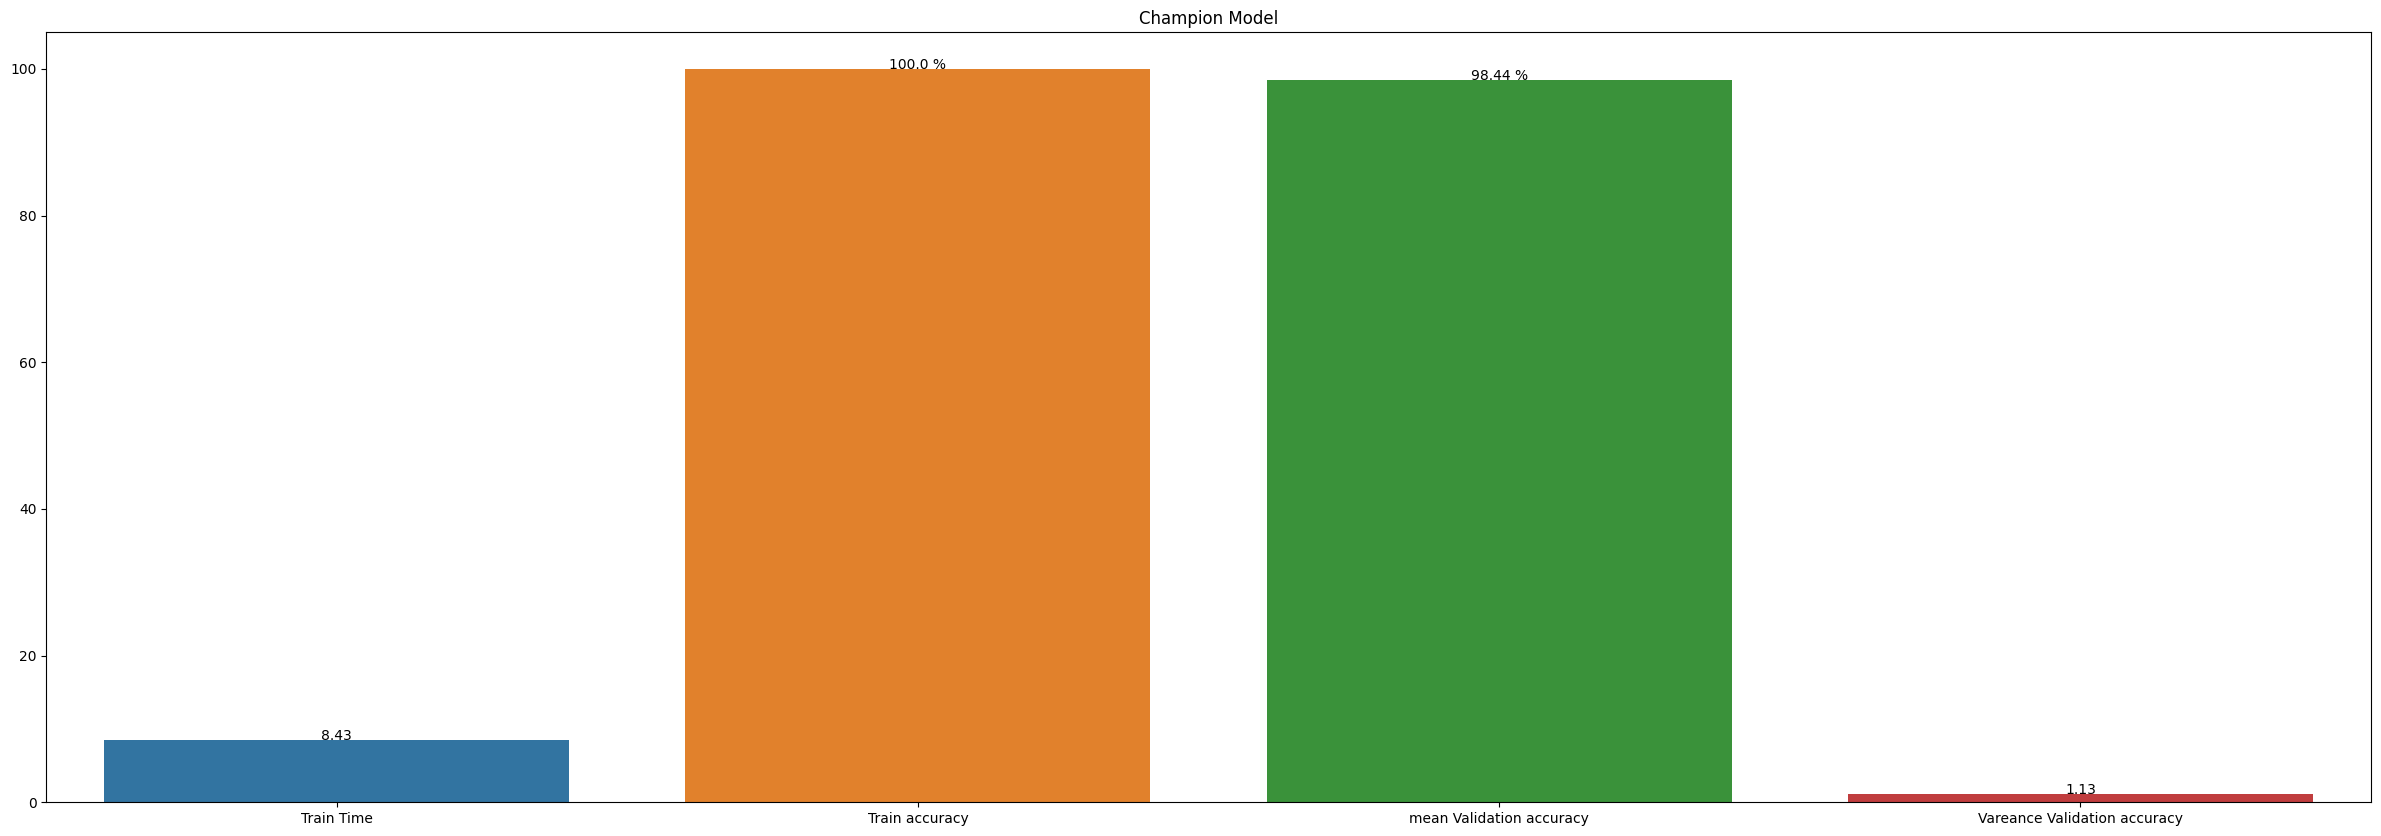

In [ ]:
d=[]
for i in data[champion]:
  d.append(i)
plt.figure(figsize=(30,10))

plt.title("Champion Model")
g=sns.barplot(x=['Train Time','Train accuracy','mean Validation accuracy','Vareance Validation accuracy'], y=d)

counter=0
for va in data[champion]:
  if counter==0 or counter==3:
    v=round(va,2)
    f=False
  else:
    v=str(round(va,2))+' %'
  g.text(counter,va,v, color='black', ha="center")
  counter+=1
plt.show()

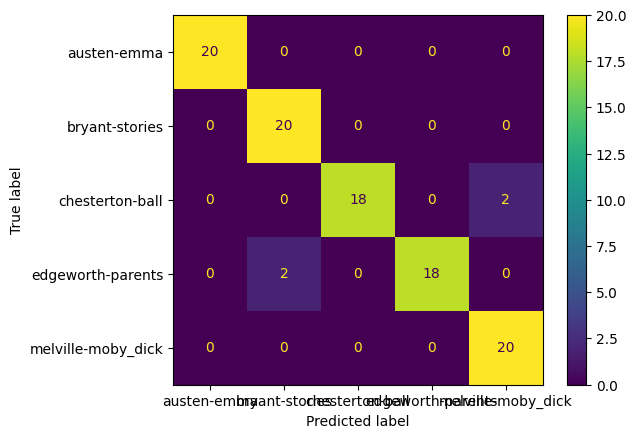

Accuracy of model: 96.00%


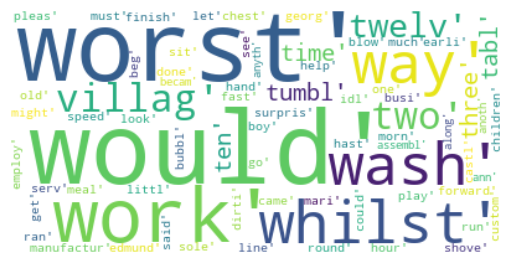

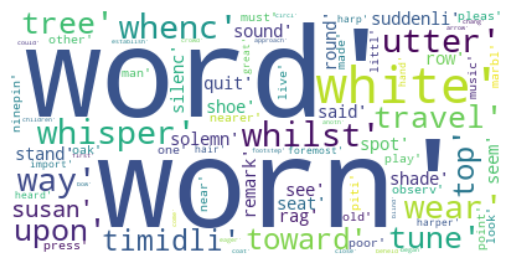

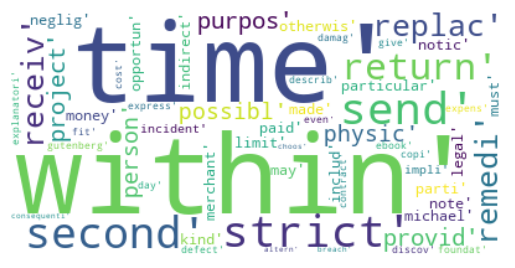

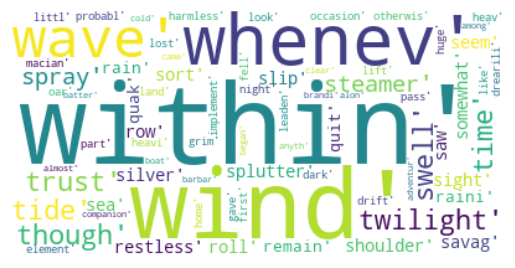

[0 0 0 0 0]


******

Wrong Predictions




Partitions austen-emma.txt  \
0  [[would, worst, work, whilst, way, wash, villa...                   
1  [[worn, word, white, whisper, whilst, whenc, w...                   
2  [[within, time, strict, send, second, return, ...                   
3  [[within, wind, whenev, wave, twilight, trust,...                   

  melville-moby_dick.txt bryant-stories.txt edgeworth-parents.txt  \
0                                                                   
1                                                                   
2                                                                   
3                                                                   

  chesterton-ball.txt bryant-stories melville-moby_dick  
0                              --X--                NaN  
1                              --X--                NaN  
2                                NaN              --X--  
3                                NaN              --X--

In [ ]:
X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,champions[0],True)
Test_Model(models[champion],test_set[champions[0]][0],list(test_set[champions[0]][1]),chosen_books,courpus)

<hr style="border: solid 3px Brown;">
<a id="17"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Track varying of champion model </span></center>

### Error_analysis1 function to track the lake of features 

In [ ]:
def Error_analysis1(model_name,feature_method,chosen_books,k_folds=10):
  track_word=[]
  track_train=[]
  track_mean=[]
  track_var=[]
  for i in range(1,12):
    df = make_df(chosen_books,words_num=i*10)
    x=df.iloc[:,0]
    y=df.iloc[:,-1]
    X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature_method,True)
    name=feature_method+' with '+model_name
    print('training using {} and {} '.format(feature_method,(model_name)))
    model=get_model(model_name)
    print('apply Cross cross validation with {} fold .'.format(k_folds))
    run_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,k_folds)
    track_word.append(i*10)
    track_train.append(train)
    track_mean.append(mean)
    track_var.append(var)
  df_vis = pd.DataFrame({
  'words number': track_word, 
  'Train Accuracy': track_train,
  'Mean validation Accuracy': track_mean,
  'vareance of validation Accuracy': track_var})
  return df_vis


### Error_analysis2 function to track the lake of data 

In [ ]:
def Error_analysis2(model_name,feature_method,chosen_books,k_folds=10):
  track_word=[]
  track_train=[]
  track_mean=[]
  track_var=[]
  for i in range(1,12):
    df = make_df(chosen_books,part_num=i*20)
    x=df.iloc[:,0]
    y=df.iloc[:,-1]
    X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature_method,True)
    name=feature_method+' with '+model_name
    print('training using {} and {} '.format(feature_method,(model_name)))
    model=get_model(model_name)
    print('apply Cross cross validation with {} fold .'.format(k_folds))
    run_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,k_folds)
    track_word.append(i*20)
    track_train.append(train)
    track_mean.append(mean)
    track_var.append(var)
  df_vis = pd.DataFrame({
  'partations number': track_word, 
  'Train Accuracy': track_train,
  'Mean validation Accuracy': track_mean,
  'vareance of validation Accuracy': track_var})
  return df_vis

  

### Error_analysis3 function to track the effect of remove stop word and stemmer  

In [ ]:
def Error_analysis3(model_name,feature_method,chosen_books,k_folds=10):
    track_word=[]
    track_train=[]
    track_mean=[]
    track_var=[]

    df = make_df(chosen_books,flg_stemm=False ,flg_stop=False)
    x=df.iloc[:,0]
    y=df.iloc[:,-1]
    X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature_method,True)
    name=feature_method+' with '+model_name
    print('training using {} and {} '.format(feature_method,(model_name)))
    model=get_model(model_name)
    print('apply Cross cross validation with {} fold .'.format(10))
    run_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,10)
    track_word.append('without stemmer and remove stop word')
    track_train.append(train)
    track_mean.append(mean)
    track_var.append(var)


    df = make_df(chosen_books,flg_stemm=False ,flg_stop=True)
    x=df.iloc[:,0]
    y=df.iloc[:,-1]
    X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature_method,True)
    name=feature_method+' with '+model_name
    print('training using {} and {} '.format(feature_method,(model_name)))
    model=get_model(model_name)
    print('apply Cross cross validation with {} fold .'.format(10))
    run_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,10)
    track_word.append('without stemmer and with remove stop word')
    track_train.append(train)
    track_mean.append(mean)
    track_var.append(var)

    df = make_df(chosen_books,flg_stemm=True ,flg_stop=False)
    x=df.iloc[:,0]
    y=df.iloc[:,-1]
    X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature_method,True)
    name=feature_method+' with '+model_name
    print('training using {} and {} '.format(feature_method,(model_name)))
    model=get_model(model_name)
    print('apply Cross cross validation with {} fold .'.format(10))
    run_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,10)
    track_word.append('with stemmer and without remove stop word')
    track_train.append(train)
    track_mean.append(mean)
    track_var.append(var)

    df = make_df(chosen_books,flg_stemm=True ,flg_stop=True)
    x=df.iloc[:,0]
    y=df.iloc[:,-1]
    X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,feature_method,True)
    name=feature_method+' with '+model_name
    print('training using {} and {} '.format(feature_method,(model_name)))
    model=get_model(model_name)
    print('apply Cross cross validation with {} fold .'.format(10))
    run_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,10)
    track_word.append('with stemmer and with remove stop word')
    track_train.append(train)
    track_mean.append(mean)
    track_var.append(var)

    df_vis = pd.DataFrame({
    'partations number': track_word, 
    'Train Accuracy': track_train,
    'Mean validation Accuracy': track_mean,
    'vareance of validation Accuracy': track_var})
    return df_vis
  

<a id="18"></a> <br>
### Track lack of features  

Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 7342

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 11198

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines: 925
The total number of words is: 53068 
The total number of words after removing sp

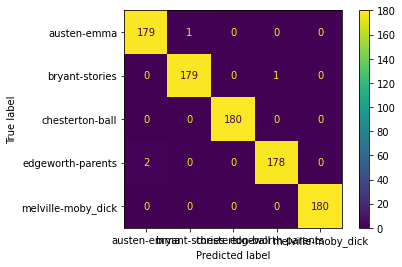

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 3671

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 5599

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headline

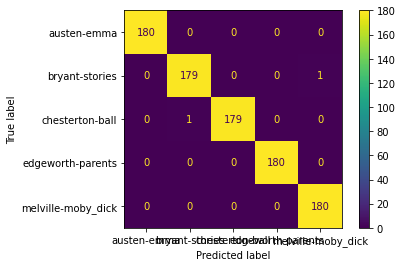

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 2447

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 3732

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headline

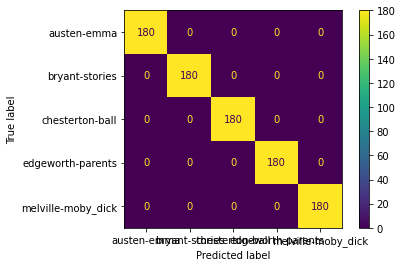

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 1835

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 2799

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headline

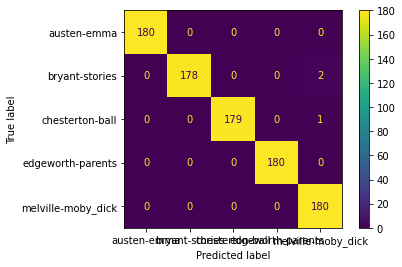

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 1468

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 2239

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headline

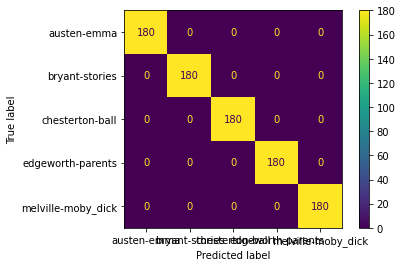

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 1223

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1866

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headline

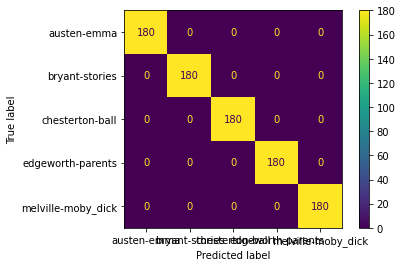

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 1048

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1599

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headline

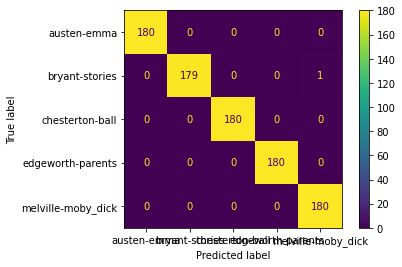

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 917

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1399

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

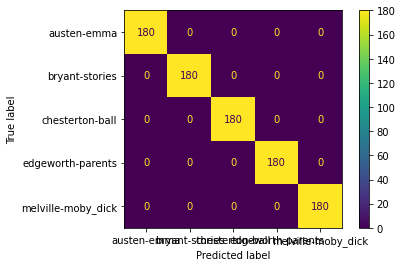

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 815

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1244

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

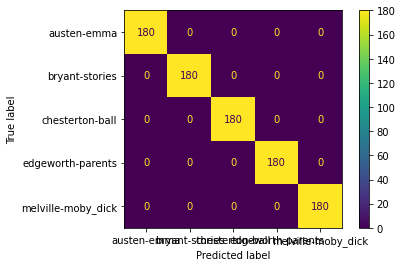

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

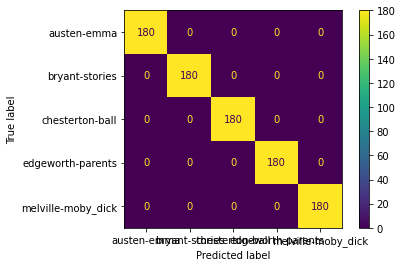

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 667

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1018

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

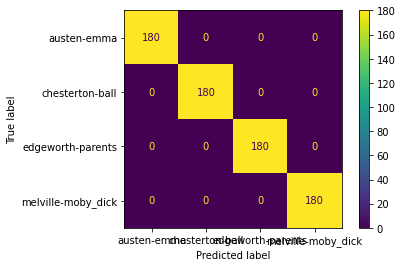

***************************************************************************************


In [ ]:
df_vis=Error_analysis1(champions[1],champions[0],chosen_books) 

In [ ]:
df_vis

words number  Train Accuracy  Mean validation Accuracy  \
0             10       99.555556                 61.777778   
1             20       99.777778                 80.888889   
2             30      100.000000                 87.888889   
3             40       99.666667                 92.000000   
4             50      100.000000                 94.888889   
5             60      100.000000                 95.666667   
6             70       99.888889                 96.444444   
7             80      100.000000                 97.333333   
8             90      100.000000                 98.111111   
9            100      100.000000                 98.444444   
10           110      100.000000                 99.722222   

    vareance of validation Accuracy  
0                          4.222222  
1                          2.572408  
2                          3.121016  
3                          1.845916  
4                          2.819684  
5                          1.953155  
6                          1.295767  
7                          2.393407  
8                          1.222222  
9                          1.586984  
10                         0.555556

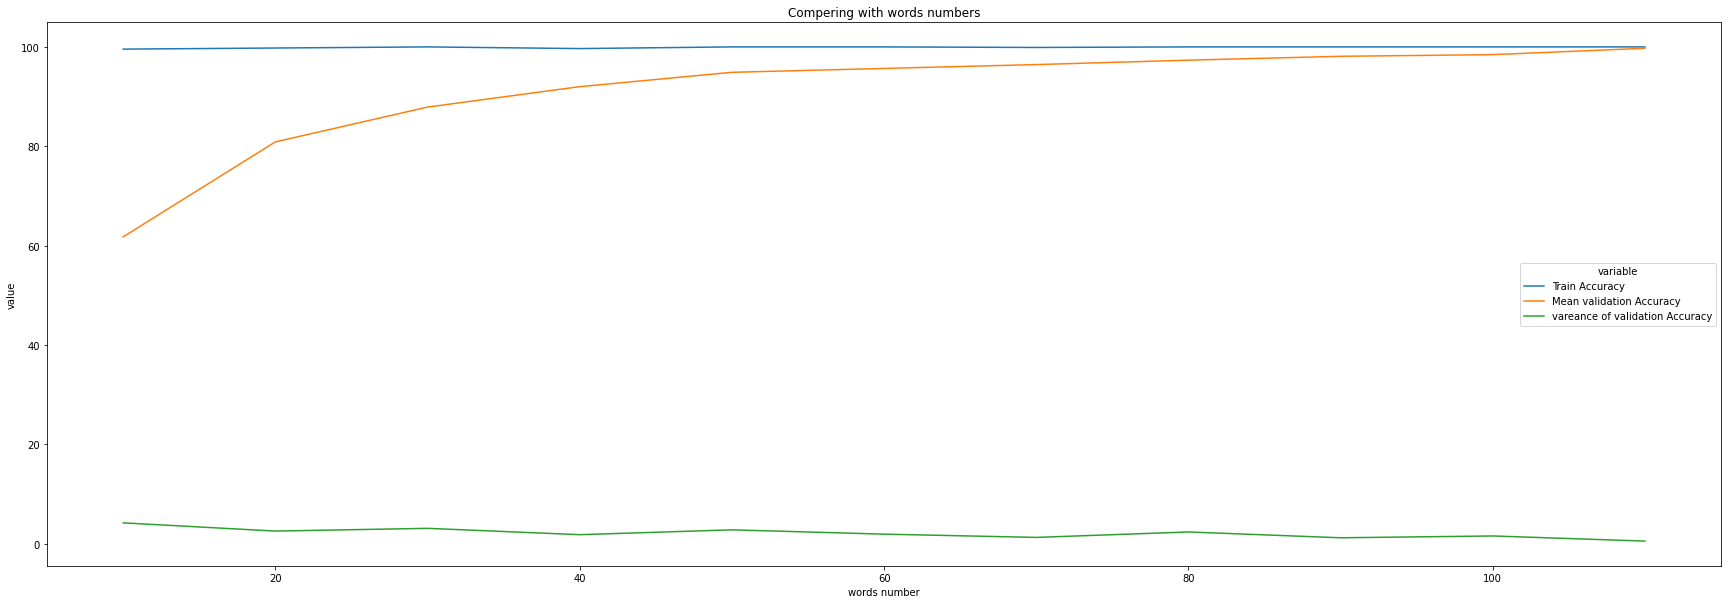

In [ ]:
 plt.figure(figsize=(30,10))
 plt.title("Compering with words numbers")
 sns.lineplot(x='words number', y='value', hue='variable', 
          data=pd.melt(df_vis, ['words number']))
 plt.show()

<a id="19"></a> <br>
### Track lack of data  

Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines: 925
The total number of words is: 53068 
The total number of words after removing spec

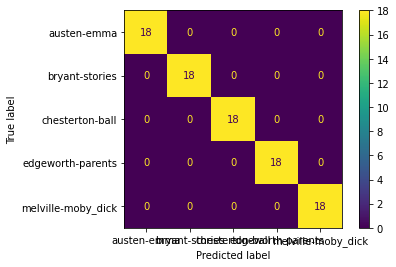

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

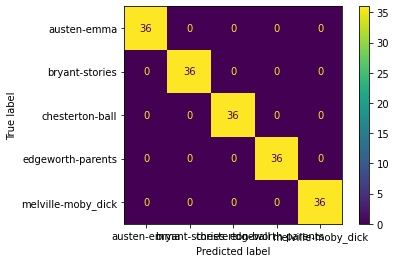

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

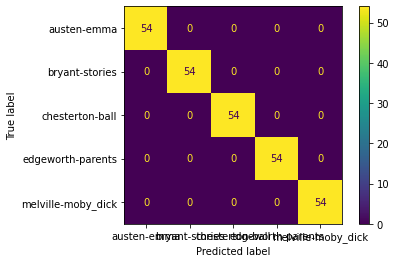

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

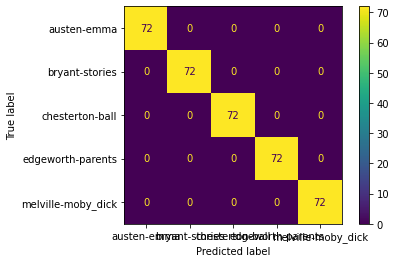

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

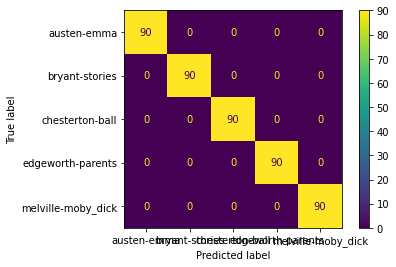

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

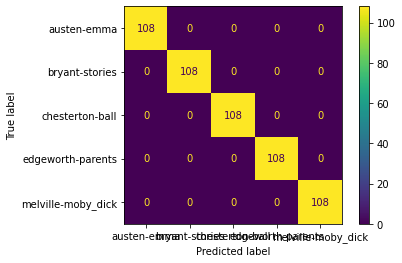

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

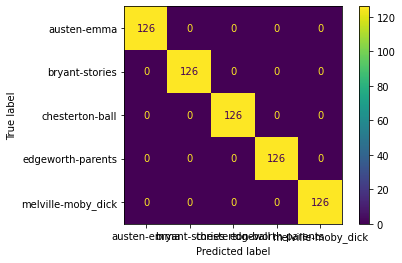

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

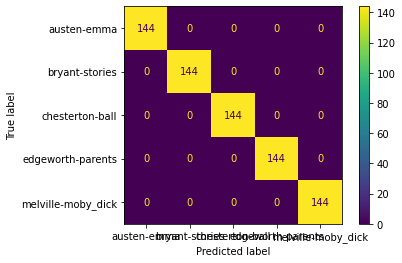

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

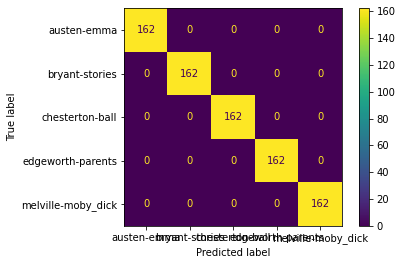

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

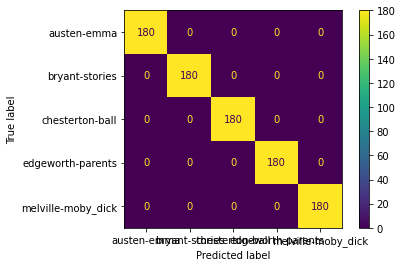

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

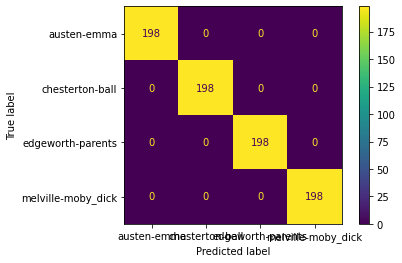

***************************************************************************************


In [ ]:
df_vis=Error_analysis2(champions[1],champions[0],chosen_books) 

In [ ]:
df_vis

partations number  Train Accuracy  Mean validation Accuracy  \
0                  20           100.0                 83.333333   
1                  40           100.0                 92.222222   
2                  60           100.0                 96.666667   
3                  80           100.0                 95.833333   
4                 100           100.0                 97.777778   
5                 120           100.0                 98.518519   
6                 140           100.0                 98.095238   
7                 160           100.0                 97.777778   
8                 180           100.0                 98.148148   
9                 200           100.0                 98.111111   
10                220           100.0                 98.863924   

    vareance of validation Accuracy  
0                         11.385501  
1                          5.665577  
2                          2.592593  
3                          3.977173  
4                          1.405457  
5                          1.614407  
6                          1.982539  
7                          1.416394  
8                          1.265056  
9                          1.319371  
10                         0.885646

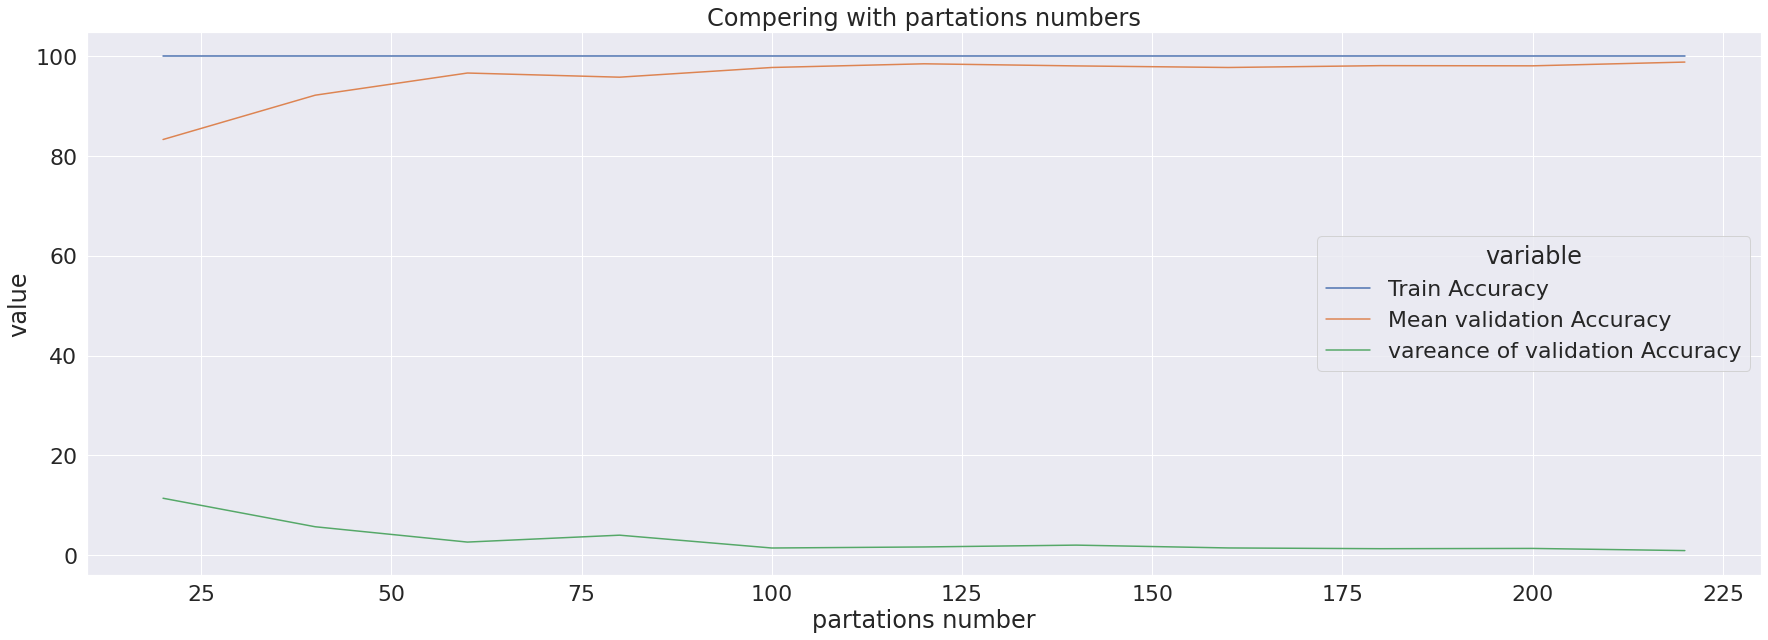

In [ ]:
plt.figure(figsize=(30,10))
plt.title("Compering with partations numbers")
sns.lineplot(x='partations number', y='value', hue='variable', 
        data=pd.melt(df_vis, ['partations number']))
plt.show()

<a id="20"></a> <br>
### Track stemmer and remove stop word effect on model  

Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of partitions is 1611

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of partitions is 2189

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines: 925
The total number of words is: 53068 
The total number of words after removing special characters and digits is: 45319
The total number of partitions is 453

Working with edgeworth-parents book
The total num

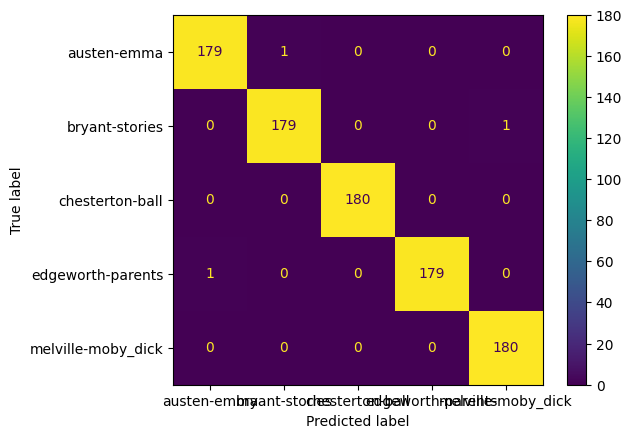

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

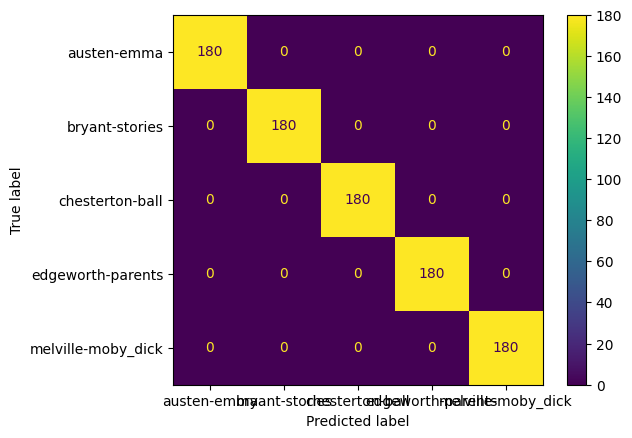

***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of partitions is 1611

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of partitions is 2189

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines: 925
The total number of words is: 53068 
The total number of words after removing special characters and digits is: 45319


***************************************************************************************
Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of words after removing stop words is: 73424
The total number of partitions is 734

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of words after removing stop words is: 111984
The total number of partitions is 1119

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines

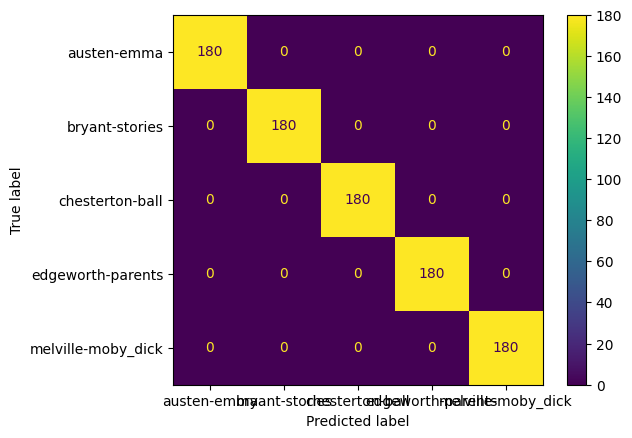

***************************************************************************************


In [ ]:
df_vis=Error_analysis3(champions[1],champions[0],chosen_books) 

In [ ]:
df_vis

partations number  Train Accuracy  \
0       without stemmer and remove stop word       99.666667   
1  without stemmer and with remove stop word      100.000000   
2  with stemmer and without remove stop word       99.777778   
3     with stemmer and with remove stop word      100.000000   

   Mean validation Accuracy  vareance of validation Accuracy  
0                 92.222222                         2.854496  
1                 98.444444                         1.237281  
2                 89.666667                         3.584948  
3                 98.888889                         0.702728

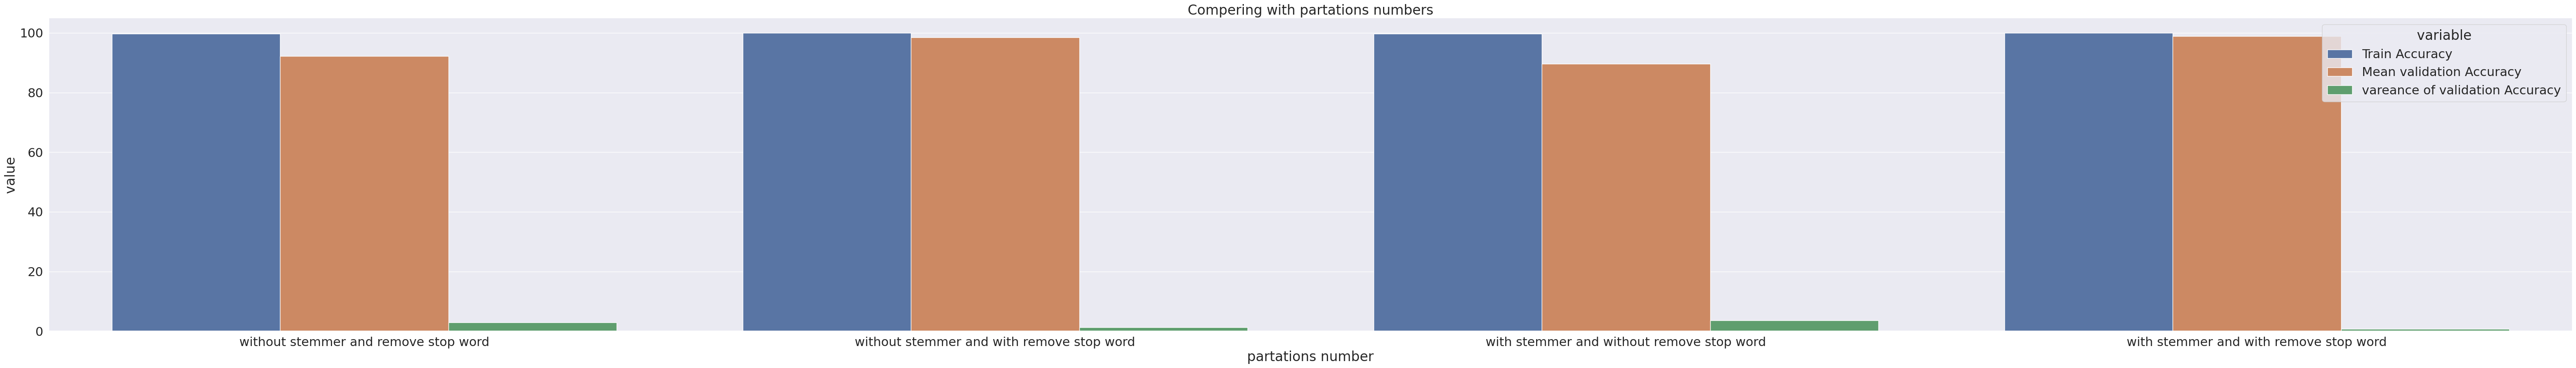

In [ ]:
plt.figure(figsize=(80,10))
plt.title("Compering with partations numbers")
sns.barplot(x='partations number', y='value', hue='variable', 
        data=pd.melt(df_vis, ['partations number']))
plt.show()

<hr style="border: solid 3px Brown;">
<a id="21"></a> <br>

## <center><span style="font-family:Arial; font-style: italic;">Retrain of champion model with data augmentation techniques </span></center>

### make_df_data_augment create new data with data augmentation techniques

In [ ]:
def make_df_data_augment(list_books, words_num=50, part_num=10):
  """
    INPUT:
    list_books: list of books to get the text from
    words_num: the number of real data words per partition
    part_num: the number of partitions per book

    OUTPUT:
    df: The data frame contains n partitions from each book in the list of books and each
       partition contains n real data words and nearly another n augmented data words

  """

  # Getting the origindal data
  print("Getting the data that will be augmented")
  print()
  df_orig = make_df(list_books, words_num, part_num, flg_stemm=False, flg_stop=False)

  # Making an empty data frame
  df = df_orig.copy()

  # initialize tokenizer and model from pretrained GPT2 model
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  model = GPT2LMHeadModel.from_pretrained('gpt2')

  print("\nThe number of words in each partition will be printed\n")

  # Making the new data frame
  df_orig = df_orig.drop(['list_of_words'],axis=1)
  for index, row in df_orig.iterrows():
    df['book_name'][index]= row['book_name']
    inputs = tokenizer.encode(row['text'], return_tensors='pt')
    outputs = model.generate(inputs, max_length=words_num*2, do_sample=True)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    text = clean(text, flg_stemm=False, flg_stop=False)
    df['list_of_words'][index] = text
    df['text'][index] = ' '.join(text)

  return df

In [ ]:
df2 =make_df_data_augment(chosen_books,50,100) 

Getting the data that will be augmented

Working with austen-emma book
The total number of paragraphs before removing headlines: 2371
The total number of paragraphs after removing headlines: 2075
The total number of words is: 189860 
The total number of words after removing special characters and digits is: 161146
The total number of partitions is 3222

Working with melville-moby_dick book
The total number of paragraphs before removing headlines: 2793
The total number of paragraphs after removing headlines: 2268
The total number of words is: 257444 
The total number of words after removing special characters and digits is: 218981
The total number of partitions is 4379

Working with bryant-stories book
The total number of paragraphs before removing headlines: 1194
The total number of paragraphs after removing headlines: 925
The total number of words is: 53068 
The total number of words after removing special characters and digits is: 45319
The total number of partitions is 906

Working 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



The number of words in each partition will be printed



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 69


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 99


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 69


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 70


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 75


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 99


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 59


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 75


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 66


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 75


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 72


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 61


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 63


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 65


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 78


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 59


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 77


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 78


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 74


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 79


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 81


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 75


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 99


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 73


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 83


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 99


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 98


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 76


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 96


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 95


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 92


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 93


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 67


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 80


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 89


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 84


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 85


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 86


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 91


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 88


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 82


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 87


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The total number of words after removing special characters and digits is: 94
The total number of words after removing special characters and digits is: 90


training using TF-IDF and logistic regression 
apply Cross cross validation with 10 fold .
Confusion Matrixtrain on Train data
train accuracy: 98.66666666666667
mean of accuracies: 64.44444444444444
variance : 6.516834799384524


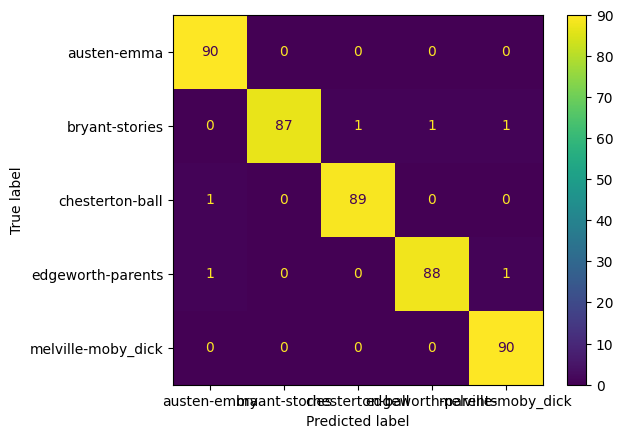

***************************************************************************************
Confusion Matrixtrain on Test data
mean of accuracies: 64.44444444444444
variance : 6.516834799384524
Test accuracies: 0.76


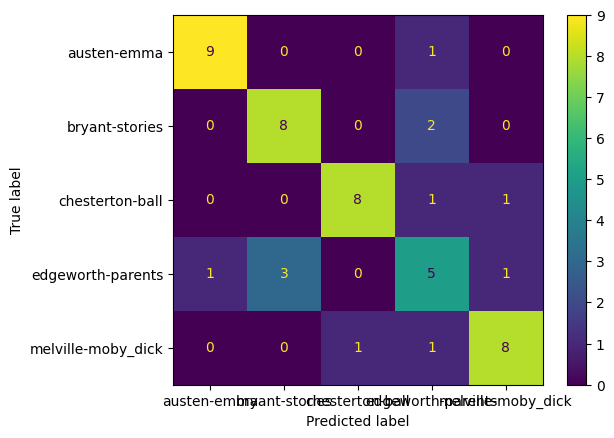

In [ ]:

x=df2.iloc[:,0]
y=df2.iloc[:,-1]

X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(x,y,champions[0],True)

print('training using {} and {} '.format(champions[0],(champions[1])))
model=get_model(champions[1])
print('apply Cross cross validation with {} fold .'.format(10))
print('Confusion Matrixtrain on Train data')
Train_time,train,mean,var=Evaluate_by_Cross_Validation(X_train,y_train,model,10)
print('Confusion Matrixtrain on Test data')
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)
print("===============================================")
print('mean of accuracies:',mean)
print('variance :',var)
print('Test accuracies:',model.score(X_test,y_test))
print("===============================================")